Parts of the code is borrowed from https://github.com/Thytu/The-Lottery-Ticket-Hypothesis

In [ ]:
import torch
import torch.nn as nn
from typing import Tuple
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torch import randperm as torch_randperm

from torch.nn import Module
from torch.optim import Optimizer
from typing import Optional, Tuple
from torch.utils.data import DataLoader
from torch.cuda import is_available as cuda_is_available
from torch import device as torch_device, eq as torch_eq, argmax as torch_argmax, no_grad as torch_no_grad

from tqdm import tqdm
from copy import deepcopy
from torch.optim import Adam
from torch.nn.utils import prune
from torch.nn import CrossEntropyLoss, Module
from torch.cuda import is_available as cuda_is_available
from torch import device as get_device, sum as torch_sum
import pickle

Architecture

In [ ]:
class LeNet(nn.Module):
    """
    Lenet-300-100 architecture (LeCun et al., 1998)
    """

    def __init__(self):
        super(LeNet, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=300),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=300, out_features=100),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=100, out_features=10),
        )

    def forward(self, input_tensor):
        input_tensor = torch.flatten(
            input = input_tensor,
            start_dim = 1
        )
        y = self.classifier(input_tensor)
        return y



Data

In [ ]:
class EarlyStopper:
    """
    Credit : https://stackoverflow.com/a/73704579/12625642
    """

    def __init__(self, patience=1, min_delta=0):

        self.patience = patience
        self.min_delta = min_delta

        self.counter = 0
        self.min_validation_loss = float('inf')

    def __call__(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            self.counter += 1

            if self.counter >= self.patience:
                return True

        return False

In [ ]:
def get_transform() -> transforms.Compose:
    """
    Get Compose transform for the MNIST dataset

    Returns:
        transforms.Compose: transform for the MNIST dataset
    """

    normalize_transform = transforms.Normalize(
        mean=(0.1307,),
        std=(0.3081,)
    )

    return transforms.Compose([
        transforms.ToTensor(),
        normalize_transform,
    ])


def get_data_loaders(**kwargs) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_set = MNIST(
        root=kwargs.get("root", './data'),
        train=True,
        transform=get_transform(),
        download=True
    )

    shuffled_indices = torch_randperm(len(train_set))

    val_set = Subset(
        dataset=train_set,
        indices=shuffled_indices[:5_000]
    )

    train_set = Subset(
        dataset=train_set,
        indices=shuffled_indices[5_000:]
    )

    test_set = MNIST(
        root=kwargs.get("root", './data'),
        train=False,
        transform=get_transform(),
        download=True
    )

    return DataLoader(
        dataset=train_set,
        batch_size=kwargs.get("batch_size", 32),
        shuffle=True,
        num_workers=kwargs.get("num_workers", 1)
    ), DataLoader(
        dataset=test_set,
        batch_size=kwargs.get("batch_size", 32),
        shuffle=True,
        num_workers=kwargs.get("num_workers", 1)
    ), DataLoader(
        dataset=val_set,
        batch_size=kwargs.get("batch_size", 32),
        shuffle=True,
        num_workers=kwargs.get("num_workers", 1)
    )

### Training

In [ ]:
def calc_accurary(preds, y_true) -> float:
    return (sum(torch_eq(torch_argmax(preds, dim=1), y_true)) / len(preds)).item()


In [ ]:


def train_model(
    model: Module,
    dataloader: DataLoader,
    optimizer: Optimizer,
    criterion: Module,
    training_iteration: int,
    max_training_iter: int,
    device: Optional[torch_device] = None,
) -> Tuple[float, float]:
    """
    Train the model given the provided data, optimizer and criterion

    Args:
        model (Module): model to train
        dataloader (DataLoader): data to train the model on
        optimizer (Optimizer): optimizer to use
        criterion (Module): criterion to optimize
        training_iteration (int): current training iteration
        max_training_iter (int): used to stop the training when >= training_iteration max_training_iter
        device (Optional[torch_device], optional): device to use. Defaults to None.

    Returns:
        Tuple[float, float]: loss and accuracy at the end of the training
    """

    model.train()

    if not device:
        device = torch_device("cuda" if cuda_is_available() else "cpu")

    step_losses = []
    step_accuracies = []

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        training_iteration += 1

        step_losses.append(loss.item())
        step_accuracies.append(calc_accurary(outputs, labels))

        if training_iteration >= max_training_iter:
            break

    return sum(step_losses) / len(step_losses), sum(step_accuracies) / len(step_accuracies), training_iteration

In [ ]:
def test_model(
    model: Module,
    dataloader: DataLoader,
    criterion: Module,
    device: Optional[torch_device] = None
) -> Tuple[float, float]:
    """
    test the model given the provided data and criterion

    Args:
        model (Module): model to test
        dataloader (DataLoader): data to test the model on
        criterion (Module): criterion to optimize
        device (Optional[torch_device], optional): device to use. Defaults to None.

    Returns:
        Tuple[float, float]: loss and accuracy at the end of the testing
    """

    model.eval()

    if not device:
        device = torch_device("cuda" if cuda_is_available() else "cpu")

    step_losses = []
    step_accuracies = []

    with torch_no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            step_losses.append(loss.item())
            step_accuracies.append(calc_accurary(outputs, labels))

    return sum(step_losses) / len(step_losses), sum(step_accuracies) / len(step_accuracies)

In [ ]:
def get_sparsity(model: Module) -> float:
    """
    Calculate the sparsity level given the training iteration step

    Args:
        model (Module): model the calculate the sparisty of (expects LeNet architecture)

    Returns:
        float: sparsity level given the training iteration step
    """

    return 100. * float(
        torch_sum(model.classifier[0].weight == 0)
        + torch_sum(model.classifier[2].weight == 0)
        + torch_sum(model.classifier[-1].weight == 0)
    ) / float(
        model.classifier[0].weight.nelement()
        + model.classifier[2].weight.nelement()
        + model.classifier[-1].weight.nelement()
    )

In [ ]:

def get_sparsity(model: Module) -> float:
    """
    Calculate the sparsity level given the training iteration step

    Args:
        model (Module): model the calculate the sparisty of (expects LeNet architecture)

    Returns:
        float: sparsity level given the training iteration step
    """

    return 100. * float(
        torch_sum(model.classifier[0].weight == 0)
        + torch_sum(model.classifier[2].weight == 0)
        + torch_sum(model.classifier[-1].weight == 0)
    ) / float(
        model.classifier[0].weight.nelement()
        + model.classifier[2].weight.nelement()
        + model.classifier[-1].weight.nelement()
    )



In [ ]:

def main(nb_pruning_iter, max_training_iter, p):

    DEVICE = get_device("cuda" if cuda_is_available() else "cpu")
    model = LeNet().to(DEVICE)
    INITIAL_WEIGHTS = deepcopy(model.state_dict())

    criterion = CrossEntropyLoss()
    optimizer = Adam(
        params=model.parameters(),
        lr=1.2e-3,
    )

    EARLY_STOP_PATIENCE = 2

    (train_dataloader, test_dataloader, val_dataloader) = get_data_loaders(batch_size=60, num_workers=4)

    test_losses = {}
    test_accuracies = {}
    early_stop_iteration_steps = {}

    # 'n' is the paper represents the number of pruning iterations
    for n in tqdm(range(1, nb_pruning_iter + 1), total=nb_pruning_iter, leave=False):
        pbar = tqdm(total=max_training_iter, leave=False)
        current_sparsiry = get_sparsity(model=model)

        # print("Sparsity working")
        test_losses[current_sparsiry] = {}
        test_accuracies[current_sparsiry] = {}

        early_stop = None

        early_stopper = EarlyStopper(patience=EARLY_STOP_PATIENCE)
        # print("Early stopper works")
        training_iteration = 0

        while training_iteration < max_training_iter:

            print("hi while loop", training_iteration)

            last_training_iteration = training_iteration
            # print("Train_model function started")
            train_loss, train_acc, training_iteration = train_model(
                model=model,
                dataloader=train_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                training_iteration=training_iteration,
                max_training_iter=max_training_iter,
                device=DEVICE
            )
            # print("Train model ended")
            test_loss, test_acc = test_model(
                model=model,
                dataloader=test_dataloader,
                criterion=criterion,
                device=DEVICE
            )
            # print("test model works")
            val_loss, _ = test_model(
                model=model,
                dataloader=val_dataloader,
                criterion=criterion,
                device=DEVICE
            )
            # print("val on test model workds")

            if early_stop is None and early_stopper(val_loss):
                early_stop = training_iteration - (training_iteration - last_training_iteration) * EARLY_STOP_PATIENCE

            test_losses[current_sparsiry][training_iteration] = test_loss
            test_accuracies[current_sparsiry][training_iteration] = test_acc

            pbar.set_description(f"{train_loss=:.2f} {train_acc=:.2f} {test_loss=:.2f} {test_acc=:.2f}")
            pbar.update(training_iteration - last_training_iteration)

        if early_stop is None:
            early_stop = training_iteration

        early_stop_iteration_steps[current_sparsiry] = early_stop

        pbar.close()

        pruning_rate = p ** (1 / n)

        prune.l1_unstructured(model.classifier[0], name="weight", amount=pruning_rate)
        prune.l1_unstructured(model.classifier[2], name="weight", amount=pruning_rate)
        prune.l1_unstructured(model.classifier[-1], name="weight", amount=pruning_rate / 2)

        # Reset weights
        reseted_weights = deepcopy(model.state_dict())
        for param in reseted_weights.keys():
            if param.split(".")[-1].replace("_orig", "") in ("bias", "weight"):
                reseted_weights[param] = deepcopy(INITIAL_WEIGHTS[param.replace("_orig", "")])

        model.load_state_dict(reseted_weights)

    return test_losses, test_accuracies, early_stop_iteration_steps

In [ ]:
from typing import Dict, List
from matplotlib import pyplot as plt


def __plot_test_losses(
    losses: Dict[float, Dict[float, float]],
    mins: Dict[float, Dict[float, float]],
    maxs: Dict[float, Dict[float, float]],
) -> None:
    """
    Plot the evolution of the loss regarding the sparsity level and iteration step

    Args:
        losses (Dict[float, Dict[float, float]]): Dict containing the mean losses regarding the sparsity level and iteration step
        mins (Dict[float, Dict[float, float]]): Dict containing the min losses regarding the sparsity level and iteration step
        maxs (Dict[float, Dict[float, float]]): Dict containing the max losses regarding the sparsity level and iteration step
    """

    plt.clf()

    plt.figure(figsize=(20, 10))
    plt.tight_layout()

    sparsity_levels = [round(sparsity_level, 2) for sparsity_level in losses.keys()]

    for sparsity_level, key in zip(sparsity_levels, losses.keys()):
        yerr = (list(mins[key].values()), list(maxs[key].values()))

        plt.errorbar(list(losses[key].keys()), list(losses[key].values()), yerr=yerr, fmt='+--', label=f"{100 - sparsity_level:.2f}%")

    plt.xlabel("Training iterations",fontdict={'fontsize': 18})
    plt.ylabel("Loss on the test set",fontdict={'fontsize': 18})
    plt.title("Model's loss regarding the fraction of weights remaining in the network after pruning.",fontdict={'fontsize': 18})
    plt.legend(loc='best')
    plt.show()
    #plt.savefig("images/losses.png", bbox_inches='tight', pad_inches=0.1)


def __plot_test_accuracies(
    accuracies: Dict[float, Dict[float, float]],
    mins: Dict[float, Dict[float, float]],
    maxs: Dict[float, Dict[float, float]],
) -> None:
    """
    Plot the evolution of the accuracy regarding the sparsity level and iteration step

    Args:
        accuracies (Dict[float, Dict[float, float]]): Dict containing the mean accuracies regarding the sparsity level and iteration step
        mins (Dict[float, Dict[float, float]]): Dict containing the min accuracies regarding the sparsity level and iteration step
        maxs (Dict[float, Dict[float, float]]): Dict containing the max accuracies regarding the sparsity level and iteration step
    """

    plt.clf()

    plt.figure(figsize=(20, 10))
    plt.tight_layout()

    sparsity_levels = [round(sparsity_level, 2) for sparsity_level in accuracies.keys()]

    for sparsity_level, key in zip(sparsity_levels, accuracies.keys()):
        yerr = (list(mins[key].values()), list(maxs[key].values()))

        plt.errorbar(list(accuracies[key].keys()), list(accuracies[key].values()), linewidth=2.0,yerr=yerr, fmt='+--', label=f"{100 - sparsity_level:.2f}%")

    plt.xlabel("Training iterations",fontdict={'fontsize': 18})
    plt.ylabel("Accuracy on the test set",fontdict={'fontsize': 18})
    plt.title("Model's accuracy regarding the fraction of weights remaining in the network after pruning.",fontdict={'fontsize': 18})
    plt.legend(loc='best')
    plt.show()
    #plt.savefig("images/accuracies.png", bbox_inches='tight', pad_inches=0.1)


def __plot_early_stops(
    early_stops: Dict[float, Dict[float, float]],
    mins: Dict[float, Dict[float, float]],
    maxs: Dict[float, Dict[float, float]],
) -> None:
    """
    Plot the evolution of the accuracy regarding the sparsity level and iteration step

    Args:
        early_stops (Dict[float, Dict[float, float]]): Dict containing the mean early stop step regarding the sparsity level and iteration step
        mins (Dict[float, Dict[float, float]]): Dict containing the min early stop step regarding the sparsity level and iteration step
        maxs (Dict[float, Dict[float, float]]): Dict containing the max early stop step regarding the sparsity level and iteration step
    """

    plt.clf()

    plt.figure(figsize=(20, 10))
    plt.tight_layout()

    plt.gca().invert_xaxis()

    percentage_of_weights_remaining = [round(100 - sparsity_level, 2) for sparsity_level in early_stops.keys()]

    yerr = (list(mins.values()), list(maxs.values()))
    plt.errorbar(percentage_of_weights_remaining, list(early_stops.values()), yerr=yerr, fmt='+--')

    plt.xlabel("Percent of Weights Remaining",fontdict={'fontsize': 16})
    plt.ylabel("Early-Stop Iteration (Val.)",fontdict={'fontsize': 16})
    plt.title("The early-stopping iteration of the iterative lottery ticket experiment.",fontdict={'fontsize': 16})
    plt.show()
    #plt.savefig("images/early_stop.png", bbox_inches='tight', pad_inches=0.1)


def plot_experiment(
    test_losses: List[Dict[float, Dict[float, float]]],
    test_accuracies: List[Dict[float, Dict[float, float]]],
    early_stops_in_each_runs: List[Dict[float, float]],
):
    """
    Plot the experiment's results (test loss, test accuracy, early stop)

    Args:
        test_losses (List[Dict[float, Dict[float, float]]]): evolution of the test loss in each run
        test_accuracies (List[Dict[float, Dict[float, float]]]): evolution of the test accuracy in each run
    """

    early_stops = {}
    min_early_stops = {}
    max_early_stops = {}

    losses = {}
    min_losses = {}
    max_losses = {}

    accuracies = {}
    min_accuracies = {}
    max_accuracies = {}

    nb_run = len(test_losses)
    nb_run = 4
    for sparsity in test_losses[0].keys():
        print(sparsity)
        losses[sparsity] = {}
        min_losses[sparsity] = {}
        max_losses[sparsity] = {}

        accuracies[sparsity] = {}
        min_accuracies[sparsity] = {}
        max_accuracies[sparsity] = {}

        early_stops_at_sparsity = [early_stops_in_each_runs[run][sparsity] for run in range(nb_run)]

        early_stops[sparsity] = sum(early_stops_at_sparsity) / nb_run
        min_early_stops[sparsity] = abs(early_stops[sparsity] - min(early_stops_at_sparsity))
        max_early_stops[sparsity] = abs(early_stops[sparsity] - max(early_stops_at_sparsity))

        for training_iteration in test_losses[0][sparsity].keys():
            loss_run_values = [test_losses[run][sparsity][training_iteration] for run in range(nb_run)]
            acc_run_values = [test_accuracies[run][sparsity][training_iteration] for run in range(nb_run)]

            losses[sparsity][training_iteration] = sum(loss_run_values) / len(loss_run_values)
            min_losses[sparsity][training_iteration] = abs(losses[sparsity][training_iteration] - min(loss_run_values))
            max_losses[sparsity][training_iteration] = abs(losses[sparsity][training_iteration] - max(loss_run_values))

            accuracies[sparsity][training_iteration] = sum(acc_run_values) / len(acc_run_values)
            min_accuracies[sparsity][training_iteration] = abs(accuracies[sparsity][training_iteration] - min(loss_run_values))
            max_accuracies[sparsity][training_iteration] = abs(accuracies[sparsity][training_iteration] - max(loss_run_values))

    __plot_test_losses(losses, min_losses, max_losses)
    __plot_test_accuracies(accuracies, min_losses, max_losses)
    __plot_early_stops(early_stops, min_early_stops, max_early_stops)


In [ ]:
P = 0.2
NB_RUN = 5
NB_PRUNING_ITER = 7
MAX_TRAINING_ITER = 15_000

early_stops = []
test_losses = []
test_accuracies = []

for run in tqdm(range(NB_RUN)):
    print("hi")
    test_losses_in_run, test_accuracies_in_run, early_stops_in_run = main(
        nb_pruning_iter=NB_PRUNING_ITER,
        max_training_iter=MAX_TRAINING_ITER,
        p=P
    )
    print(run)
    test_losses.append(test_losses_in_run)
    test_accuracies.append(test_accuracies_in_run)
    early_stops.append(early_stops_in_run)



  0%|          | 0/5 [00:00<?, ?it/s]

hi



100%|██████████| 9912422/9912422 [00:00<00:00, 84652480.27it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 28881/28881 [00:00<00:00, 32216939.85it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw





100%|██████████| 1648877/1648877 [00:00<00:00, 22940334.28it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 11101706.74it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.23 train_acc=0.93 test_loss=0.14 test_acc=0.96:   0%|          | 0/15000 [00:10<?, ?it/s]

train_loss=0.23 train_acc=0.93 test_loss=0.14 test_acc=0.96:   6%|▌         | 917/15000 [00:10<02:35, 90.51it/s]

hi while loop 917




train_loss=0.09 train_acc=0.97 test_loss=0.10 test_acc=0.97:   6%|▌         | 917/15000 [00:19<02:35, 90.51it/s]

train_loss=0.09 train_acc=0.97 test_loss=0.10 test_acc=0.97:  12%|█▏        | 1834/15000 [00:19<02:15, 96.97it/s]

hi while loop 1834




train_loss=0.07 train_acc=0.98 test_loss=0.09 test_acc=0.97:  12%|█▏        | 1834/15000 [00:27<02:15, 96.97it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.09 test_acc=0.97:  18%|█▊        | 2751/15000 [00:27<02:00, 101.41it/s]

hi while loop 2751




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  18%|█▊        | 2751/15000 [00:36<02:00, 101.41it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:36<01:50, 103.00it/s]

hi while loop 3668




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  24%|██▍       | 3668/15000 [00:44<01:50, 103.00it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  31%|███       | 4585/15000 [00:44<01:39, 104.34it/s]

hi while loop 4585




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.98:  31%|███       | 4585/15000 [00:53<01:39, 104.34it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [00:53<01:31, 103.73it/s]

hi while loop 5502




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [01:02<01:31, 103.73it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  43%|████▎     | 6419/15000 [01:02<01:21, 104.80it/s]

hi while loop 6419




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  43%|████▎     | 6419/15000 [01:10<01:21, 104.80it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  49%|████▉     | 7336/15000 [01:10<01:12, 105.63it/s]

hi while loop 7336




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:19<01:12, 105.63it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:19<01:03, 106.66it/s]

hi while loop 8253




train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:28<01:03, 106.66it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  61%|██████    | 9170/15000 [01:28<00:55, 105.49it/s]

hi while loop 9170




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:37<00:55, 105.49it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:37<00:46, 104.87it/s]

hi while loop 10087




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:45<00:46, 104.87it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:45<00:37, 105.47it/s]

hi while loop 11004




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:54<00:37, 105.47it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:54<00:29, 104.50it/s]

hi while loop 11921




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:03<00:29, 104.50it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:03<00:20, 104.39it/s]

hi while loop 12838




train_loss=0.02 train_acc=1.00 test_loss=0.12 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:12<00:20, 104.39it/s]

train_loss=0.02 train_acc=1.00 test_loss=0.12 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:12<00:11, 105.21it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:20<00:11, 105.21it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:20<00:03, 106.09it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:25<00:03, 106.09it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98: 100%|██████████| 15000/15000 [02:25<00:00, 99.96it/s] 

                                                                                                                  
 14%|█▍        | 1/7 [02:25<14:30, 145.09s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.20 train_acc=0.94 test_loss=0.11 test_acc=0.97:   0%|          | 0/15000 [00:09<?, ?it/s]

train_loss=0.20 train_acc=0.94 test_loss=0.11 test_acc=0.97:   6%|▌         | 917/15000 [00:09<02:21, 99.65it/s]

hi while loop 917




train_loss=0.08 train_acc=0.98 test_loss=0.08 test_acc=0.98:   6%|▌         | 917/15000 [00:18<02:21, 99.65it/s]

train_loss=0.08 train_acc=0.98 test_loss=0.08 test_acc=0.98:  12%|█▏        | 1834/15000 [00:18<02:09, 101.84it/s]

hi while loop 1834




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  12%|█▏        | 1834/15000 [00:26<02:09, 101.84it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  18%|█▊        | 2751/15000 [00:26<01:58, 102.96it/s]

hi while loop 2751




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:58, 102.96it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:50, 102.56it/s]

hi while loop 3668




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:44<01:50, 102.56it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:44<01:40, 103.16it/s]

hi while loop 4585




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:53<01:40, 103.16it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [00:53<01:31, 103.69it/s]

hi while loop 5502




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [01:02<01:31, 103.69it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:02<01:22, 103.90it/s]

hi while loop 6419




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  43%|████▎     | 6419/15000 [01:11<01:22, 103.90it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  49%|████▉     | 7336/15000 [01:11<01:15, 102.02it/s]

hi while loop 7336




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  49%|████▉     | 7336/15000 [01:20<01:15, 102.02it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:20<01:05, 102.53it/s]

hi while loop 8253




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:29<01:05, 102.53it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  61%|██████    | 9170/15000 [01:29<00:56, 102.67it/s]

hi while loop 9170




train_loss=0.02 train_acc=0.99 test_loss=0.12 test_acc=0.98:  61%|██████    | 9170/15000 [01:38<00:56, 102.67it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.12 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:38<00:48, 101.82it/s]

hi while loop 10087




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:47<00:48, 101.82it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:47<00:39, 102.16it/s]

hi while loop 11004




train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:56<00:39, 102.16it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:56<00:29, 102.96it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:04<00:29, 102.96it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:04<00:20, 103.80it/s]

hi while loop 12838




train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:14<00:20, 103.80it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:14<00:12, 102.31it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.15 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:22<00:12, 102.31it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.15 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:22<00:03, 102.97it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.15 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:27<00:03, 102.97it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.15 test_acc=0.98: 100%|██████████| 15000/15000 [02:27<00:00, 97.71it/s] 

                                                                                                                  
 29%|██▊       | 2/7 [04:52<12:11, 146.39s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.21 train_acc=0.93 test_loss=0.11 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.21 train_acc=0.93 test_loss=0.11 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:13, 105.44it/s]

hi while loop 917




train_loss=0.07 train_acc=0.98 test_loss=0.09 test_acc=0.97:   6%|▌         | 917/15000 [00:17<02:13, 105.44it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.09 test_acc=0.97:  12%|█▏        | 1834/15000 [00:17<02:07, 102.91it/s]

hi while loop 1834




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  12%|█▏        | 1834/15000 [00:26<02:07, 102.91it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  18%|█▊        | 2751/15000 [00:26<01:57, 103.98it/s]

hi while loop 2751




train_loss=0.04 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:57, 103.98it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:48, 104.41it/s]

hi while loop 3668




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:44<01:48, 104.41it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:44<01:41, 102.85it/s]

hi while loop 4585




train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  31%|███       | 4585/15000 [00:53<01:41, 102.85it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  37%|███▋      | 5502/15000 [00:53<01:32, 102.91it/s]

hi while loop 5502




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [01:01<01:32, 102.91it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:02<01:22, 103.51it/s]

hi while loop 6419




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  43%|████▎     | 6419/15000 [01:10<01:22, 103.51it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  49%|████▉     | 7336/15000 [01:10<01:13, 103.68it/s]

hi while loop 7336




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:20<01:13, 103.68it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:20<01:05, 102.36it/s]

hi while loop 8253




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:28<01:05, 102.36it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:28<00:56, 103.01it/s]

hi while loop 9170




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  61%|██████    | 9170/15000 [01:37<00:56, 103.01it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:37<00:47, 103.71it/s]

hi while loop 10087




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:46<00:47, 103.71it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:46<00:38, 103.81it/s]

hi while loop 11004




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:55<00:38, 103.81it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:55<00:29, 102.63it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:04<00:29, 102.63it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:04<00:20, 102.98it/s]

hi while loop 12838




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:13<00:20, 102.98it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:13<00:12, 103.38it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:22<00:12, 103.38it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:22<00:03, 102.27it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:26<00:03, 102.27it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98: 100%|██████████| 15000/15000 [02:26<00:00, 97.29it/s] 

                                                                                                                  
 43%|████▎     | 3/7 [07:19<09:46, 146.56s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.21 train_acc=0.94 test_loss=0.08 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.21 train_acc=0.94 test_loss=0.08 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:13, 105.63it/s]

hi while loop 917




train_loss=0.06 train_acc=0.98 test_loss=0.07 test_acc=0.98:   6%|▌         | 917/15000 [00:17<02:13, 105.63it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:17<02:05, 104.81it/s]

hi while loop 1834




train_loss=0.04 train_acc=0.99 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:26<02:05, 104.81it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:26<01:59, 102.60it/s]

hi while loop 2751




train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:59, 102.60it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:49, 103.12it/s]

hi while loop 3668




train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:44<01:49, 103.12it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  31%|███       | 4585/15000 [00:44<01:40, 103.23it/s]

hi while loop 4585




train_loss=0.01 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:53<01:40, 103.23it/s]

train_loss=0.01 train_acc=0.99 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [00:53<01:31, 103.36it/s]

hi while loop 5502




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [01:02<01:31, 103.36it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:02<01:24, 102.12it/s]

hi while loop 6419




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:11<01:24, 102.12it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:11<01:14, 103.38it/s]

hi while loop 7336




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  49%|████▉     | 7336/15000 [01:19<01:14, 103.38it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:19<01:05, 103.41it/s]

hi while loop 8253




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:28<01:05, 103.41it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:28<00:56, 102.53it/s]

hi while loop 9170




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  61%|██████    | 9170/15000 [01:37<00:56, 102.53it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:37<00:47, 103.26it/s]

hi while loop 10087




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:46<00:47, 103.26it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:46<00:38, 103.60it/s]

hi while loop 11004




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:55<00:38, 103.60it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:55<00:29, 103.49it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:04<00:29, 103.49it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:04<00:21, 102.25it/s]

hi while loop 12838




train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:13<00:21, 102.25it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:13<00:12, 102.78it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:22<00:12, 102.78it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:22<00:03, 102.71it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:26<00:03, 102.71it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98: 100%|██████████| 15000/15000 [02:26<00:00, 97.27it/s] 

                                                                                                                  
 57%|█████▋    | 4/7 [09:46<07:20, 146.70s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.26 train_acc=0.93 test_loss=0.09 test_acc=0.97:   0%|          | 0/15000 [00:09<?, ?it/s]

train_loss=0.26 train_acc=0.93 test_loss=0.09 test_acc=0.97:   6%|▌         | 917/15000 [00:09<02:19, 101.00it/s]

hi while loop 917




train_loss=0.06 train_acc=0.98 test_loss=0.06 test_acc=0.98:   6%|▌         | 917/15000 [00:17<02:19, 101.00it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.06 test_acc=0.98:  12%|█▏        | 1834/15000 [00:17<02:08, 102.55it/s]

hi while loop 1834




train_loss=0.04 train_acc=0.99 test_loss=0.06 test_acc=0.98:  12%|█▏        | 1834/15000 [00:26<02:08, 102.55it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.06 test_acc=0.98:  18%|█▊        | 2751/15000 [00:26<01:58, 103.25it/s]

hi while loop 2751




train_loss=0.03 train_acc=0.99 test_loss=0.06 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:58, 103.25it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.06 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:50, 102.93it/s]

hi while loop 3668




train_loss=0.02 train_acc=0.99 test_loss=0.06 test_acc=0.98:  24%|██▍       | 3668/15000 [00:44<01:50, 102.93it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.06 test_acc=0.98:  31%|███       | 4585/15000 [00:44<01:42, 102.09it/s]

hi while loop 4585




train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  31%|███       | 4585/15000 [00:53<01:42, 102.09it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  37%|███▋      | 5502/15000 [00:53<01:32, 102.62it/s]

hi while loop 5502




train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  37%|███▋      | 5502/15000 [01:02<01:32, 102.62it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  43%|████▎     | 6419/15000 [01:02<01:23, 102.74it/s]

hi while loop 6419




train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  43%|████▎     | 6419/15000 [01:11<01:23, 102.74it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  49%|████▉     | 7336/15000 [01:11<01:15, 101.96it/s]

hi while loop 7336




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:20<01:15, 101.96it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:20<01:05, 102.95it/s]

hi while loop 8253




train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:29<01:05, 102.95it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  61%|██████    | 9170/15000 [01:29<00:56, 103.37it/s]

hi while loop 9170




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:38<00:56, 103.37it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:38<00:47, 103.58it/s]

hi while loop 10087




train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:47<00:47, 103.58it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:47<00:38, 102.47it/s]

hi while loop 11004




train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:56<00:38, 102.47it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:56<00:29, 102.72it/s]

hi while loop 11921




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:04<00:29, 102.72it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:04<00:20, 103.44it/s]

hi while loop 12838




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:13<00:20, 103.44it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:13<00:12, 102.97it/s]

hi while loop 13755




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:22<00:12, 102.97it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:22<00:03, 103.89it/s]

hi while loop 14672




train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:26<00:03, 103.89it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98: 100%|██████████| 15000/15000 [02:26<00:00, 98.56it/s] 

                                                                                                                  
 71%|███████▏  | 5/7 [12:12<04:53, 146.76s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.47 train_acc=0.85 test_loss=0.14 test_acc=0.96:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.47 train_acc=0.85 test_loss=0.14 test_acc=0.96:   6%|▌         | 917/15000 [00:08<02:16, 103.21it/s]

hi while loop 917




train_loss=0.12 train_acc=0.97 test_loss=0.11 test_acc=0.96:   6%|▌         | 917/15000 [00:17<02:16, 103.21it/s]

train_loss=0.12 train_acc=0.97 test_loss=0.11 test_acc=0.96:  12%|█▏        | 1834/15000 [00:17<02:09, 101.77it/s]

hi while loop 1834




train_loss=0.09 train_acc=0.97 test_loss=0.10 test_acc=0.97:  12%|█▏        | 1834/15000 [00:26<02:09, 101.77it/s]

train_loss=0.09 train_acc=0.97 test_loss=0.10 test_acc=0.97:  18%|█▊        | 2751/15000 [00:26<01:59, 102.92it/s]

hi while loop 2751




train_loss=0.08 train_acc=0.98 test_loss=0.09 test_acc=0.97:  18%|█▊        | 2751/15000 [00:35<01:59, 102.92it/s]

train_loss=0.08 train_acc=0.98 test_loss=0.09 test_acc=0.97:  24%|██▍       | 3668/15000 [00:35<01:48, 104.19it/s]

hi while loop 3668




train_loss=0.07 train_acc=0.98 test_loss=0.09 test_acc=0.97:  24%|██▍       | 3668/15000 [00:44<01:48, 104.19it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.09 test_acc=0.97:  31%|███       | 4585/15000 [00:44<01:39, 104.76it/s]

hi while loop 4585




train_loss=0.06 train_acc=0.98 test_loss=0.08 test_acc=0.97:  31%|███       | 4585/15000 [00:53<01:39, 104.76it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.08 test_acc=0.97:  37%|███▋      | 5502/15000 [00:53<01:31, 103.96it/s]

hi while loop 5502




train_loss=0.05 train_acc=0.98 test_loss=0.09 test_acc=0.97:  37%|███▋      | 5502/15000 [01:01<01:31, 103.96it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.09 test_acc=0.97:  43%|████▎     | 6419/15000 [01:01<01:22, 103.66it/s]

hi while loop 6419




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.97:  43%|████▎     | 6419/15000 [01:10<01:22, 103.66it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.97:  49%|████▉     | 7336/15000 [01:10<01:14, 103.47it/s]

hi while loop 7336




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  49%|████▉     | 7336/15000 [01:19<01:14, 103.47it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:19<01:05, 103.11it/s]

hi while loop 8253




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.97:  55%|█████▌    | 8253/15000 [01:29<01:05, 103.11it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.97:  61%|██████    | 9170/15000 [01:29<00:57, 101.78it/s]

hi while loop 9170




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  61%|██████    | 9170/15000 [01:37<00:57, 101.78it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:37<00:48, 102.33it/s]

hi while loop 10087




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:46<00:48, 102.33it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:46<00:38, 102.51it/s]

hi while loop 11004




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  73%|███████▎  | 11004/15000 [01:56<00:38, 102.51it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  79%|███████▉  | 11921/15000 [01:56<00:30, 101.68it/s]

hi while loop 11921




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:05<00:30, 101.68it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:05<00:21, 101.61it/s]

hi while loop 12838




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:14<00:21, 101.61it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:14<00:12, 101.60it/s]

hi while loop 13755




train_loss=0.03 train_acc=0.99 test_loss=0.10 test_acc=0.97:  92%|█████████▏| 13755/15000 [02:22<00:12, 101.60it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.10 test_acc=0.97:  98%|█████████▊| 14672/15000 [02:22<00:03, 102.25it/s]

hi while loop 14672




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.97:  98%|█████████▊| 14672/15000 [02:27<00:03, 102.25it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.97: 100%|██████████| 15000/15000 [02:27<00:00, 95.21it/s] 

                                                                                                                  
 86%|████████▌ | 6/7 [14:40<02:27, 147.15s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=2.00 train_acc=0.28 test_loss=0.98 test_acc=0.69:   0%|          | 0/15000 [00:09<?, ?it/s]

train_loss=2.00 train_acc=0.28 test_loss=0.98 test_acc=0.69:   6%|▌         | 917/15000 [00:09<02:19, 101.10it/s]

hi while loop 917




train_loss=0.70 train_acc=0.78 test_loss=0.54 test_acc=0.83:   6%|▌         | 917/15000 [00:18<02:19, 101.10it/s]

train_loss=0.70 train_acc=0.78 test_loss=0.54 test_acc=0.83:  12%|█▏        | 1834/15000 [00:18<02:11, 100.16it/s]

hi while loop 1834




train_loss=0.52 train_acc=0.84 test_loss=0.48 test_acc=0.85:  12%|█▏        | 1834/15000 [00:27<02:11, 100.16it/s]

train_loss=0.52 train_acc=0.84 test_loss=0.48 test_acc=0.85:  18%|█▊        | 2751/15000 [00:27<02:01, 101.20it/s]

hi while loop 2751




train_loss=0.45 train_acc=0.86 test_loss=0.42 test_acc=0.87:  18%|█▊        | 2751/15000 [00:36<02:01, 101.20it/s]

train_loss=0.45 train_acc=0.86 test_loss=0.42 test_acc=0.87:  24%|██▍       | 3668/15000 [00:36<01:52, 100.32it/s]

hi while loop 3668




train_loss=0.39 train_acc=0.88 test_loss=0.38 test_acc=0.88:  24%|██▍       | 3668/15000 [00:45<01:52, 100.32it/s]

train_loss=0.39 train_acc=0.88 test_loss=0.38 test_acc=0.88:  31%|███       | 4585/15000 [00:45<01:43, 100.90it/s]

hi while loop 4585




train_loss=0.37 train_acc=0.89 test_loss=0.36 test_acc=0.89:  31%|███       | 4585/15000 [00:54<01:43, 100.90it/s]

train_loss=0.37 train_acc=0.89 test_loss=0.36 test_acc=0.89:  37%|███▋      | 5502/15000 [00:54<01:33, 101.48it/s]

hi while loop 5502




train_loss=0.35 train_acc=0.89 test_loss=0.34 test_acc=0.89:  37%|███▋      | 5502/15000 [01:03<01:33, 101.48it/s]

train_loss=0.35 train_acc=0.89 test_loss=0.34 test_acc=0.89:  43%|████▎     | 6419/15000 [01:03<01:24, 101.06it/s]

hi while loop 6419




train_loss=0.34 train_acc=0.90 test_loss=0.33 test_acc=0.90:  43%|████▎     | 6419/15000 [01:12<01:24, 101.06it/s]

train_loss=0.34 train_acc=0.90 test_loss=0.33 test_acc=0.90:  49%|████▉     | 7336/15000 [01:12<01:15, 102.02it/s]

hi while loop 7336




train_loss=0.33 train_acc=0.90 test_loss=0.33 test_acc=0.90:  49%|████▉     | 7336/15000 [01:21<01:15, 102.02it/s]

train_loss=0.33 train_acc=0.90 test_loss=0.33 test_acc=0.90:  55%|█████▌    | 8253/15000 [01:21<01:05, 102.69it/s]

hi while loop 8253




train_loss=0.32 train_acc=0.90 test_loss=0.32 test_acc=0.90:  55%|█████▌    | 8253/15000 [01:29<01:05, 102.69it/s]

train_loss=0.32 train_acc=0.90 test_loss=0.32 test_acc=0.90:  61%|██████    | 9170/15000 [01:29<00:56, 103.29it/s]

hi while loop 9170




train_loss=0.32 train_acc=0.90 test_loss=0.31 test_acc=0.90:  61%|██████    | 9170/15000 [01:39<00:56, 103.29it/s]

train_loss=0.32 train_acc=0.90 test_loss=0.31 test_acc=0.90:  67%|██████▋   | 10087/15000 [01:39<00:47, 102.60it/s]

hi while loop 10087




train_loss=0.31 train_acc=0.90 test_loss=0.31 test_acc=0.91:  67%|██████▋   | 10087/15000 [01:47<00:47, 102.60it/s]

train_loss=0.31 train_acc=0.90 test_loss=0.31 test_acc=0.91:  73%|███████▎  | 11004/15000 [01:47<00:38, 103.22it/s]

hi while loop 11004




train_loss=0.31 train_acc=0.90 test_loss=0.31 test_acc=0.91:  73%|███████▎  | 11004/15000 [01:56<00:38, 103.22it/s]

train_loss=0.31 train_acc=0.90 test_loss=0.31 test_acc=0.91:  79%|███████▉  | 11921/15000 [01:56<00:29, 103.15it/s]

hi while loop 11921




train_loss=0.31 train_acc=0.90 test_loss=0.31 test_acc=0.91:  79%|███████▉  | 11921/15000 [02:05<00:29, 103.15it/s]

train_loss=0.31 train_acc=0.90 test_loss=0.31 test_acc=0.91:  86%|████████▌ | 12838/15000 [02:05<00:21, 102.36it/s]

hi while loop 12838




train_loss=0.30 train_acc=0.91 test_loss=0.31 test_acc=0.91:  86%|████████▌ | 12838/15000 [02:14<00:21, 102.36it/s]

train_loss=0.30 train_acc=0.91 test_loss=0.31 test_acc=0.91:  92%|█████████▏| 13755/15000 [02:14<00:12, 103.32it/s]

hi while loop 13755




train_loss=0.30 train_acc=0.91 test_loss=0.31 test_acc=0.91:  92%|█████████▏| 13755/15000 [02:23<00:12, 103.32it/s]

train_loss=0.30 train_acc=0.91 test_loss=0.31 test_acc=0.91:  98%|█████████▊| 14672/15000 [02:23<00:03, 103.81it/s]

hi while loop 14672




train_loss=0.30 train_acc=0.91 test_loss=0.30 test_acc=0.91:  98%|█████████▊| 14672/15000 [02:27<00:03, 103.81it/s]

train_loss=0.30 train_acc=0.91 test_loss=0.30 test_acc=0.91: 100%|██████████| 15000/15000 [02:27<00:00, 98.45it/s] 

                                                                                                                  
 20%|██        | 1/5 [17:12<1:08:50, 1032.56s/it]

0
hi



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.22 train_acc=0.93 test_loss=0.12 test_acc=0.96:   0%|          | 0/15000 [00:09<?, ?it/s]

train_loss=0.22 train_acc=0.93 test_loss=0.12 test_acc=0.96:   6%|▌         | 917/15000 [00:09<02:19, 100.91it/s]

hi while loop 917




train_loss=0.10 train_acc=0.97 test_loss=0.10 test_acc=0.97:   6%|▌         | 917/15000 [00:17<02:19, 100.91it/s]

train_loss=0.10 train_acc=0.97 test_loss=0.10 test_acc=0.97:  12%|█▏        | 1834/15000 [00:17<02:07, 103.50it/s]

hi while loop 1834




train_loss=0.07 train_acc=0.98 test_loss=0.08 test_acc=0.98:  12%|█▏        | 1834/15000 [00:26<02:07, 103.50it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.08 test_acc=0.98:  18%|█▊        | 2751/15000 [00:26<01:57, 103.91it/s]

hi while loop 2751




train_loss=0.05 train_acc=0.98 test_loss=0.09 test_acc=0.97:  18%|█▊        | 2751/15000 [00:35<01:57, 103.91it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.09 test_acc=0.97:  24%|██▍       | 3668/15000 [00:35<01:48, 104.11it/s]

hi while loop 3668




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:44<01:48, 104.11it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:44<01:40, 103.40it/s]

hi while loop 4585




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:53<01:40, 103.40it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [00:53<01:31, 104.15it/s]

hi while loop 5502




train_loss=0.03 train_acc=0.99 test_loss=0.10 test_acc=0.97:  37%|███▋      | 5502/15000 [01:01<01:31, 104.15it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.10 test_acc=0.97:  43%|████▎     | 6419/15000 [01:01<01:21, 104.92it/s]

hi while loop 6419




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:10<01:21, 104.92it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:10<01:12, 105.04it/s]

hi while loop 7336




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  49%|████▉     | 7336/15000 [01:19<01:12, 105.04it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:19<01:04, 104.15it/s]

hi while loop 8253




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:28<01:04, 104.15it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:28<00:55, 104.30it/s]

hi while loop 9170




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:36<00:55, 104.30it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:36<00:46, 105.14it/s]

hi while loop 10087




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:45<00:46, 105.14it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:45<00:38, 104.44it/s]

hi while loop 11004




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:54<00:38, 104.44it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:54<00:29, 104.61it/s]

hi while loop 11921




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:03<00:29, 104.61it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:03<00:20, 104.64it/s]

hi while loop 12838




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:11<00:20, 104.64it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:11<00:11, 104.92it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:20<00:11, 104.92it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:20<00:03, 104.05it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:25<00:03, 104.05it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98: 100%|██████████| 15000/15000 [02:25<00:00, 98.15it/s] 

                                                                                                                  
 14%|█▍        | 1/7 [02:25<14:31, 145.28s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.21 train_acc=0.94 test_loss=0.10 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.21 train_acc=0.94 test_loss=0.10 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:13, 105.20it/s]

hi while loop 917




train_loss=0.08 train_acc=0.97 test_loss=0.09 test_acc=0.97:   6%|▌         | 917/15000 [00:17<02:13, 105.20it/s]

train_loss=0.08 train_acc=0.97 test_loss=0.09 test_acc=0.97:  12%|█▏        | 1834/15000 [00:17<02:05, 104.92it/s]

hi while loop 1834




train_loss=0.06 train_acc=0.98 test_loss=0.08 test_acc=0.98:  12%|█▏        | 1834/15000 [00:26<02:05, 104.92it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.08 test_acc=0.98:  18%|█▊        | 2751/15000 [00:26<01:58, 103.14it/s]

hi while loop 2751




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:58, 103.14it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:49, 103.82it/s]

hi while loop 3668




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:44<01:49, 103.82it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:44<01:40, 104.11it/s]

hi while loop 4585




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  31%|███       | 4585/15000 [00:52<01:40, 104.11it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [00:52<01:31, 104.08it/s]

hi while loop 5502




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [01:01<01:31, 104.08it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:01<01:23, 102.96it/s]

hi while loop 6419




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:10<01:23, 102.96it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:10<01:14, 103.31it/s]

hi while loop 7336




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  49%|████▉     | 7336/15000 [01:19<01:14, 103.31it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:19<01:04, 103.97it/s]

hi while loop 8253




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:28<01:04, 103.97it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:28<00:56, 102.86it/s]

hi while loop 9170




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:37<00:56, 102.86it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:37<00:47, 103.43it/s]

hi while loop 10087




train_loss=0.02 train_acc=0.99 test_loss=0.14 test_acc=0.97:  67%|██████▋   | 10087/15000 [01:46<00:47, 103.43it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.14 test_acc=0.97:  73%|███████▎  | 11004/15000 [01:46<00:38, 104.18it/s]

hi while loop 11004




train_loss=0.02 train_acc=1.00 test_loss=0.09 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:54<00:38, 104.18it/s]

train_loss=0.02 train_acc=1.00 test_loss=0.09 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:54<00:29, 104.61it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:03<00:29, 104.61it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:03<00:21, 102.94it/s]

hi while loop 12838




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:12<00:21, 102.94it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:12<00:12, 102.80it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:21<00:12, 102.80it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:21<00:03, 102.78it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:26<00:03, 102.78it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98: 100%|██████████| 15000/15000 [02:26<00:00, 97.19it/s] 

                                                                                                                  
 29%|██▊       | 2/7 [04:51<12:09, 145.93s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.21 train_acc=0.94 test_loss=0.09 test_acc=0.97:   0%|          | 0/15000 [00:09<?, ?it/s]

train_loss=0.21 train_acc=0.94 test_loss=0.09 test_acc=0.97:   6%|▌         | 917/15000 [00:09<02:24, 97.61it/s]

hi while loop 917




train_loss=0.07 train_acc=0.98 test_loss=0.08 test_acc=0.98:   6%|▌         | 917/15000 [00:18<02:24, 97.61it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.08 test_acc=0.98:  12%|█▏        | 1834/15000 [00:18<02:10, 100.57it/s]

hi while loop 1834




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  12%|█▏        | 1834/15000 [00:27<02:10, 100.57it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  18%|█▊        | 2751/15000 [00:27<01:59, 102.36it/s]

hi while loop 2751




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  18%|█▊        | 2751/15000 [00:36<01:59, 102.36it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:36<01:51, 101.45it/s]

hi while loop 3668




train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:45<01:51, 101.45it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  31%|███       | 4585/15000 [00:45<01:41, 102.52it/s]

hi while loop 4585




train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:53<01:41, 102.52it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [00:53<01:31, 103.27it/s]

hi while loop 5502




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [01:02<01:31, 103.27it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:02<01:23, 103.27it/s]

hi while loop 6419




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:11<01:23, 103.27it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:11<01:15, 101.93it/s]

hi while loop 7336




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:20<01:15, 101.93it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:20<01:05, 102.37it/s]

hi while loop 8253




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:29<01:05, 102.37it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:29<00:56, 103.04it/s]

hi while loop 9170




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:38<00:56, 103.04it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:38<00:47, 102.52it/s]

hi while loop 10087




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:47<00:47, 102.52it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:47<00:38, 103.32it/s]

hi while loop 11004




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:55<00:38, 103.32it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:55<00:29, 104.07it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:04<00:29, 104.07it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:04<00:20, 104.51it/s]

hi while loop 12838




train_loss=0.01 train_acc=1.00 test_loss=0.18 test_acc=0.97:  86%|████████▌ | 12838/15000 [02:13<00:20, 104.51it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.18 test_acc=0.97:  92%|█████████▏| 13755/15000 [02:13<00:11, 103.75it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:22<00:11, 103.75it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:22<00:03, 104.29it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:26<00:03, 104.29it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98: 100%|██████████| 15000/15000 [02:26<00:00, 98.71it/s] 

                                                                                                                  
 43%|████▎     | 3/7 [07:18<09:45, 146.35s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.21 train_acc=0.94 test_loss=0.09 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.21 train_acc=0.94 test_loss=0.09 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:14, 104.42it/s]

hi while loop 917




train_loss=0.06 train_acc=0.98 test_loss=0.07 test_acc=0.98:   6%|▌         | 917/15000 [00:17<02:14, 104.42it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:17<02:08, 102.22it/s]

hi while loop 1834




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  12%|█▏        | 1834/15000 [00:26<02:08, 102.22it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  18%|█▊        | 2751/15000 [00:26<01:58, 103.41it/s]

hi while loop 2751




train_loss=0.02 train_acc=0.99 test_loss=0.06 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:58, 103.41it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.06 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:49, 103.69it/s]

hi while loop 3668




train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:44<01:49, 103.69it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  31%|███       | 4585/15000 [00:44<01:40, 103.43it/s]

hi while loop 4585




train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:53<01:40, 103.43it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [00:53<01:32, 102.42it/s]

hi while loop 5502




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [01:02<01:32, 102.42it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:02<01:22, 103.52it/s]

hi while loop 6419




train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  43%|████▎     | 6419/15000 [01:10<01:22, 103.52it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  49%|████▉     | 7336/15000 [01:10<01:13, 103.73it/s]

hi while loop 7336




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  49%|████▉     | 7336/15000 [01:20<01:13, 103.73it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:20<01:06, 101.95it/s]

hi while loop 8253




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:29<01:06, 101.95it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  61%|██████    | 9170/15000 [01:29<00:56, 102.40it/s]

hi while loop 9170




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:37<00:56, 102.40it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:37<00:47, 102.99it/s]

hi while loop 10087




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:46<00:47, 102.99it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:46<00:38, 103.17it/s]

hi while loop 11004




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:55<00:38, 103.17it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:55<00:30, 102.40it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:04<00:30, 102.40it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:04<00:21, 102.61it/s]

hi while loop 12838




train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:13<00:21, 102.61it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:13<00:12, 102.85it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:22<00:12, 102.85it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:22<00:03, 102.35it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:27<00:03, 102.35it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98: 100%|██████████| 15000/15000 [02:27<00:00, 97.32it/s] 

                                                                                                                  
 57%|█████▋    | 4/7 [09:45<07:20, 146.67s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.29 train_acc=0.91 test_loss=0.09 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.29 train_acc=0.91 test_loss=0.09 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:13, 105.54it/s]

hi while loop 917




train_loss=0.07 train_acc=0.98 test_loss=0.07 test_acc=0.98:   6%|▌         | 917/15000 [00:17<02:13, 105.54it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:17<02:04, 105.88it/s]

hi while loop 1834




train_loss=0.04 train_acc=0.99 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:26<02:04, 105.88it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:26<01:57, 104.61it/s]

hi while loop 2751




train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:57, 104.61it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:48, 104.08it/s]

hi while loop 3668




train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:43<01:48, 104.08it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  31%|███       | 4585/15000 [00:43<01:39, 104.75it/s]

hi while loop 4585




train_loss=0.02 train_acc=1.00 test_loss=0.07 test_acc=0.98:  31%|███       | 4585/15000 [00:52<01:39, 104.75it/s]

train_loss=0.02 train_acc=1.00 test_loss=0.07 test_acc=0.98:  37%|███▋      | 5502/15000 [00:52<01:30, 104.99it/s]

hi while loop 5502




train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  37%|███▋      | 5502/15000 [01:01<01:30, 104.99it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  43%|████▎     | 6419/15000 [01:01<01:21, 104.72it/s]

hi while loop 6419




train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  43%|████▎     | 6419/15000 [01:09<01:21, 104.72it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  49%|████▉     | 7336/15000 [01:09<01:12, 105.14it/s]

hi while loop 7336




train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  49%|████▉     | 7336/15000 [01:18<01:12, 105.14it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:18<01:04, 105.10it/s]

hi while loop 8253




train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:27<01:04, 105.10it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  61%|██████    | 9170/15000 [01:27<00:56, 103.66it/s]

hi while loop 9170




train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  61%|██████    | 9170/15000 [01:36<00:56, 103.66it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:36<00:47, 102.55it/s]

hi while loop 10087




train_loss=0.00 train_acc=1.00 test_loss=0.08 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:45<00:47, 102.55it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.08 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:45<00:38, 103.41it/s]

hi while loop 11004




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:54<00:38, 103.41it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:54<00:29, 103.79it/s]

hi while loop 11921




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:03<00:29, 103.79it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:03<00:20, 103.57it/s]

hi while loop 12838




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:12<00:20, 103.57it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:12<00:12, 103.45it/s]

hi while loop 13755




train_loss=0.00 train_acc=1.00 test_loss=0.12 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:20<00:12, 103.45it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:20<00:03, 103.75it/s]

hi while loop 14672




train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:25<00:03, 103.75it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98: 100%|██████████| 15000/15000 [02:25<00:00, 98.02it/s] 

                                                                                                                  
 71%|███████▏  | 5/7 [12:11<04:52, 146.24s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.54 train_acc=0.84 test_loss=0.16 test_acc=0.95:   0%|          | 0/15000 [00:09<?, ?it/s]

train_loss=0.54 train_acc=0.84 test_loss=0.16 test_acc=0.95:   6%|▌         | 917/15000 [00:09<02:20, 100.26it/s]

hi while loop 917




train_loss=0.13 train_acc=0.96 test_loss=0.11 test_acc=0.97:   6%|▌         | 917/15000 [00:18<02:20, 100.26it/s]

train_loss=0.13 train_acc=0.96 test_loss=0.11 test_acc=0.97:  12%|█▏        | 1834/15000 [00:18<02:09, 101.34it/s]

hi while loop 1834




train_loss=0.09 train_acc=0.97 test_loss=0.10 test_acc=0.97:  12%|█▏        | 1834/15000 [00:27<02:09, 101.34it/s]

train_loss=0.09 train_acc=0.97 test_loss=0.10 test_acc=0.97:  18%|█▊        | 2751/15000 [00:27<02:01, 100.98it/s]

hi while loop 2751




train_loss=0.08 train_acc=0.98 test_loss=0.09 test_acc=0.97:  18%|█▊        | 2751/15000 [00:36<02:01, 100.98it/s]

train_loss=0.08 train_acc=0.98 test_loss=0.09 test_acc=0.97:  24%|██▍       | 3668/15000 [00:36<01:51, 101.97it/s]

hi while loop 3668




train_loss=0.07 train_acc=0.98 test_loss=0.09 test_acc=0.97:  24%|██▍       | 3668/15000 [00:45<01:51, 101.97it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.09 test_acc=0.97:  31%|███       | 4585/15000 [00:45<01:42, 101.94it/s]

hi while loop 4585




train_loss=0.06 train_acc=0.98 test_loss=0.09 test_acc=0.97:  31%|███       | 4585/15000 [00:53<01:42, 101.94it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.09 test_acc=0.97:  37%|███▋      | 5502/15000 [00:53<01:31, 103.57it/s]

hi while loop 5502




train_loss=0.05 train_acc=0.98 test_loss=0.09 test_acc=0.97:  37%|███▋      | 5502/15000 [01:02<01:31, 103.57it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.09 test_acc=0.97:  43%|████▎     | 6419/15000 [01:02<01:22, 104.20it/s]

hi while loop 6419




train_loss=0.05 train_acc=0.98 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:11<01:22, 104.20it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:11<01:13, 103.66it/s]

hi while loop 7336




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  49%|████▉     | 7336/15000 [01:20<01:13, 103.66it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  55%|█████▌    | 8253/15000 [01:20<01:05, 103.05it/s]

hi while loop 8253




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  55%|█████▌    | 8253/15000 [01:29<01:05, 103.05it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  61%|██████    | 9170/15000 [01:29<00:56, 103.62it/s]

hi while loop 9170




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  61%|██████    | 9170/15000 [01:37<00:56, 103.62it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  67%|██████▋   | 10087/15000 [01:37<00:47, 103.90it/s]

hi while loop 10087




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  67%|██████▋   | 10087/15000 [01:46<00:47, 103.90it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  73%|███████▎  | 11004/15000 [01:46<00:38, 102.98it/s]

hi while loop 11004




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:55<00:38, 102.98it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:55<00:29, 103.26it/s]

hi while loop 11921




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:04<00:29, 103.26it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:04<00:20, 102.99it/s]

hi while loop 12838




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.97:  86%|████████▌ | 12838/15000 [02:13<00:20, 102.99it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.97:  92%|█████████▏| 13755/15000 [02:13<00:12, 103.19it/s]

hi while loop 13755




train_loss=0.03 train_acc=0.99 test_loss=0.10 test_acc=0.97:  92%|█████████▏| 13755/15000 [02:22<00:12, 103.19it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.10 test_acc=0.97:  98%|█████████▊| 14672/15000 [02:22<00:03, 102.36it/s]

hi while loop 14672




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.97:  98%|█████████▊| 14672/15000 [02:27<00:03, 102.36it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.97: 100%|██████████| 15000/15000 [02:27<00:00, 97.12it/s] 

                                                                                                                  
 86%|████████▌ | 6/7 [14:38<02:26, 146.57s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=1.86 train_acc=0.33 test_loss=0.99 test_acc=0.68:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=1.86 train_acc=0.33 test_loss=0.99 test_acc=0.68:   6%|▌         | 917/15000 [00:08<02:16, 102.93it/s]

hi while loop 917




train_loss=0.76 train_acc=0.76 test_loss=0.61 test_acc=0.81:   6%|▌         | 917/15000 [00:17<02:16, 102.93it/s]

train_loss=0.76 train_acc=0.76 test_loss=0.61 test_acc=0.81:  12%|█▏        | 1834/15000 [00:17<02:07, 103.39it/s]

hi while loop 1834




train_loss=0.54 train_acc=0.83 test_loss=0.47 test_acc=0.86:  12%|█▏        | 1834/15000 [00:26<02:07, 103.39it/s]

train_loss=0.54 train_acc=0.83 test_loss=0.47 test_acc=0.86:  18%|█▊        | 2751/15000 [00:26<01:59, 102.34it/s]

hi while loop 2751




train_loss=0.46 train_acc=0.86 test_loss=0.43 test_acc=0.87:  18%|█▊        | 2751/15000 [00:35<01:59, 102.34it/s]

train_loss=0.46 train_acc=0.86 test_loss=0.43 test_acc=0.87:  24%|██▍       | 3668/15000 [00:35<01:49, 103.03it/s]

hi while loop 3668




train_loss=0.42 train_acc=0.87 test_loss=0.40 test_acc=0.88:  24%|██▍       | 3668/15000 [00:44<01:49, 103.03it/s]

train_loss=0.42 train_acc=0.87 test_loss=0.40 test_acc=0.88:  31%|███       | 4585/15000 [00:44<01:40, 103.53it/s]

hi while loop 4585




train_loss=0.40 train_acc=0.88 test_loss=0.39 test_acc=0.89:  31%|███       | 4585/15000 [00:53<01:40, 103.53it/s]

train_loss=0.40 train_acc=0.88 test_loss=0.39 test_acc=0.89:  37%|███▋      | 5502/15000 [00:53<01:32, 102.72it/s]

hi while loop 5502




train_loss=0.39 train_acc=0.88 test_loss=0.37 test_acc=0.89:  37%|███▋      | 5502/15000 [01:02<01:32, 102.72it/s]

train_loss=0.39 train_acc=0.88 test_loss=0.37 test_acc=0.89:  43%|████▎     | 6419/15000 [01:02<01:22, 103.71it/s]

hi while loop 6419




train_loss=0.38 train_acc=0.88 test_loss=0.37 test_acc=0.89:  43%|████▎     | 6419/15000 [01:10<01:22, 103.71it/s]

train_loss=0.38 train_acc=0.88 test_loss=0.37 test_acc=0.89:  49%|████▉     | 7336/15000 [01:10<01:13, 104.21it/s]

hi while loop 7336




train_loss=0.37 train_acc=0.89 test_loss=0.36 test_acc=0.89:  49%|████▉     | 7336/15000 [01:19<01:13, 104.21it/s]

train_loss=0.37 train_acc=0.89 test_loss=0.36 test_acc=0.89:  55%|█████▌    | 8253/15000 [01:19<01:04, 104.52it/s]

hi while loop 8253




train_loss=0.36 train_acc=0.89 test_loss=0.35 test_acc=0.89:  55%|█████▌    | 8253/15000 [01:28<01:04, 104.52it/s]

train_loss=0.36 train_acc=0.89 test_loss=0.35 test_acc=0.89:  61%|██████    | 9170/15000 [01:28<00:56, 103.09it/s]

hi while loop 9170




train_loss=0.36 train_acc=0.89 test_loss=0.35 test_acc=0.90:  61%|██████    | 9170/15000 [01:37<00:56, 103.09it/s]

train_loss=0.36 train_acc=0.89 test_loss=0.35 test_acc=0.90:  67%|██████▋   | 10087/15000 [01:37<00:47, 103.44it/s]

hi while loop 10087




train_loss=0.35 train_acc=0.89 test_loss=0.35 test_acc=0.90:  67%|██████▋   | 10087/15000 [01:46<00:47, 103.44it/s]

train_loss=0.35 train_acc=0.89 test_loss=0.35 test_acc=0.90:  73%|███████▎  | 11004/15000 [01:46<00:38, 103.75it/s]

hi while loop 11004




train_loss=0.35 train_acc=0.89 test_loss=0.34 test_acc=0.90:  73%|███████▎  | 11004/15000 [01:55<00:38, 103.75it/s]

train_loss=0.35 train_acc=0.89 test_loss=0.34 test_acc=0.90:  79%|███████▉  | 11921/15000 [01:55<00:29, 103.12it/s]

hi while loop 11921




train_loss=0.34 train_acc=0.89 test_loss=0.34 test_acc=0.90:  79%|███████▉  | 11921/15000 [02:04<00:29, 103.12it/s]

train_loss=0.34 train_acc=0.89 test_loss=0.34 test_acc=0.90:  86%|████████▌ | 12838/15000 [02:04<00:21, 102.56it/s]

hi while loop 12838




train_loss=0.34 train_acc=0.89 test_loss=0.33 test_acc=0.90:  86%|████████▌ | 12838/15000 [02:13<00:21, 102.56it/s]

train_loss=0.34 train_acc=0.89 test_loss=0.33 test_acc=0.90:  92%|█████████▏| 13755/15000 [02:13<00:12, 102.98it/s]

hi while loop 13755




train_loss=0.34 train_acc=0.90 test_loss=0.33 test_acc=0.91:  92%|█████████▏| 13755/15000 [02:21<00:12, 102.98it/s]

train_loss=0.34 train_acc=0.90 test_loss=0.33 test_acc=0.91:  98%|█████████▊| 14672/15000 [02:21<00:03, 103.58it/s]

hi while loop 14672




train_loss=0.32 train_acc=0.90 test_loss=0.33 test_acc=0.91:  98%|█████████▊| 14672/15000 [02:26<00:03, 103.58it/s]

train_loss=0.32 train_acc=0.90 test_loss=0.33 test_acc=0.91: 100%|██████████| 15000/15000 [02:26<00:00, 98.22it/s] 

                                                                                                                  
 40%|████      | 2/5 [34:17<51:24, 1028.04s/it]  

1
hi



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.23 train_acc=0.93 test_loss=0.14 test_acc=0.96:   0%|          | 0/15000 [00:09<?, ?it/s]

train_loss=0.23 train_acc=0.93 test_loss=0.14 test_acc=0.96:   6%|▌         | 917/15000 [00:09<02:18, 101.66it/s]

hi while loop 917




train_loss=0.09 train_acc=0.97 test_loss=0.09 test_acc=0.97:   6%|▌         | 917/15000 [00:17<02:18, 101.66it/s]

train_loss=0.09 train_acc=0.97 test_loss=0.09 test_acc=0.97:  12%|█▏        | 1834/15000 [00:17<02:07, 103.59it/s]

hi while loop 1834




train_loss=0.07 train_acc=0.98 test_loss=0.09 test_acc=0.97:  12%|█▏        | 1834/15000 [00:26<02:07, 103.59it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.09 test_acc=0.97:  18%|█▊        | 2751/15000 [00:26<01:56, 104.73it/s]

hi while loop 2751




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:56, 104.73it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:48, 103.98it/s]

hi while loop 3668




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  24%|██▍       | 3668/15000 [00:44<01:48, 103.98it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  31%|███       | 4585/15000 [00:44<01:39, 104.53it/s]

hi while loop 4585




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:52<01:39, 104.53it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [00:52<01:30, 104.72it/s]

hi while loop 5502




train_loss=0.03 train_acc=0.99 test_loss=0.13 test_acc=0.97:  37%|███▋      | 5502/15000 [01:01<01:30, 104.72it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.13 test_acc=0.97:  43%|████▎     | 6419/15000 [01:01<01:21, 105.58it/s]

hi while loop 6419




train_loss=0.03 train_acc=0.99 test_loss=0.10 test_acc=0.98:  43%|████▎     | 6419/15000 [01:10<01:21, 105.58it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.10 test_acc=0.98:  49%|████▉     | 7336/15000 [01:10<01:13, 104.59it/s]

hi while loop 7336




train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  49%|████▉     | 7336/15000 [01:18<01:13, 104.59it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:18<01:04, 104.92it/s]

hi while loop 8253




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:27<01:04, 104.92it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  61%|██████    | 9170/15000 [01:27<00:55, 105.70it/s]

hi while loop 9170




train_loss=0.02 train_acc=0.99 test_loss=0.12 test_acc=0.97:  61%|██████    | 9170/15000 [01:36<00:55, 105.70it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.12 test_acc=0.97:  67%|██████▋   | 10087/15000 [01:36<00:46, 105.26it/s]

hi while loop 10087




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:45<00:46, 105.26it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:45<00:38, 104.67it/s]

hi while loop 11004




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:53<00:38, 104.67it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:53<00:29, 105.27it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:02<00:29, 105.27it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:02<00:20, 105.98it/s]

hi while loop 12838




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:11<00:20, 105.98it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:11<00:11, 105.12it/s]

hi while loop 13755




train_loss=0.02 train_acc=0.99 test_loss=0.12 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:19<00:11, 105.12it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:19<00:03, 105.18it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:24<00:03, 105.18it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98: 100%|██████████| 15000/15000 [02:24<00:00, 99.69it/s] 

                                                                                                                  
 14%|█▍        | 1/7 [02:24<14:25, 144.21s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.21 train_acc=0.94 test_loss=0.12 test_acc=0.96:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.21 train_acc=0.94 test_loss=0.12 test_acc=0.96:   6%|▌         | 917/15000 [00:08<02:10, 107.51it/s]

hi while loop 917




train_loss=0.08 train_acc=0.97 test_loss=0.09 test_acc=0.97:   6%|▌         | 917/15000 [00:17<02:10, 107.51it/s]

train_loss=0.08 train_acc=0.97 test_loss=0.09 test_acc=0.97:  12%|█▏        | 1834/15000 [00:17<02:05, 104.71it/s]

hi while loop 1834




train_loss=0.06 train_acc=0.98 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:26<02:05, 104.71it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:26<01:56, 104.70it/s]

hi while loop 2751




train_loss=0.04 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:56, 104.70it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:48, 104.11it/s]

hi while loop 3668




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  24%|██▍       | 3668/15000 [00:43<01:48, 104.11it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  31%|███       | 4585/15000 [00:43<01:39, 104.33it/s]

hi while loop 4585




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  31%|███       | 4585/15000 [00:52<01:39, 104.33it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [00:52<01:32, 102.97it/s]

hi while loop 5502




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [01:01<01:32, 102.97it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:01<01:22, 103.81it/s]

hi while loop 6419




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:10<01:22, 103.81it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:10<01:13, 104.41it/s]

hi while loop 7336




train_loss=0.02 train_acc=0.99 test_loss=0.12 test_acc=0.97:  49%|████▉     | 7336/15000 [01:19<01:13, 104.41it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.12 test_acc=0.97:  55%|█████▌    | 8253/15000 [01:19<01:05, 103.76it/s]

hi while loop 8253




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:28<01:05, 103.76it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  61%|██████    | 9170/15000 [01:28<00:56, 103.86it/s]

hi while loop 9170




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  61%|██████    | 9170/15000 [01:36<00:56, 103.86it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:36<00:47, 104.35it/s]

hi while loop 10087




train_loss=0.01 train_acc=0.99 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:45<00:47, 104.35it/s]

train_loss=0.01 train_acc=0.99 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:45<00:38, 104.69it/s]

hi while loop 11004




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:54<00:38, 104.69it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:54<00:29, 103.38it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:03<00:29, 103.38it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:03<00:20, 104.07it/s]

hi while loop 12838




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:11<00:20, 104.07it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:11<00:11, 104.86it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:20<00:11, 104.86it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:20<00:03, 105.43it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:25<00:03, 105.43it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98: 100%|██████████| 15000/15000 [02:25<00:00, 98.06it/s] 

                                                                                                                  
 29%|██▊       | 2/7 [04:49<12:04, 144.89s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.22 train_acc=0.93 test_loss=0.09 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.22 train_acc=0.93 test_loss=0.09 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:15, 104.29it/s]

hi while loop 917




train_loss=0.07 train_acc=0.98 test_loss=0.08 test_acc=0.97:   6%|▌         | 917/15000 [00:17<02:15, 104.29it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.08 test_acc=0.97:  12%|█▏        | 1834/15000 [00:17<02:05, 105.04it/s]

hi while loop 1834




train_loss=0.05 train_acc=0.98 test_loss=0.09 test_acc=0.97:  12%|█▏        | 1834/15000 [00:26<02:05, 105.04it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.09 test_acc=0.97:  18%|█▊        | 2751/15000 [00:26<01:56, 105.49it/s]

hi while loop 2751




train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:56, 105.49it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:49, 103.67it/s]

hi while loop 3668




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:43<01:49, 103.67it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:43<01:39, 104.58it/s]

hi while loop 4585




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  31%|███       | 4585/15000 [00:52<01:39, 104.58it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [00:52<01:30, 104.92it/s]

hi while loop 5502




train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [01:01<01:30, 104.92it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  43%|████▎     | 6419/15000 [01:01<01:23, 103.29it/s]

hi while loop 6419




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:10<01:23, 103.29it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:10<01:13, 103.91it/s]

hi while loop 7336




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:19<01:13, 103.91it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:19<01:04, 104.31it/s]

hi while loop 8253




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:27<01:04, 104.31it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  61%|██████    | 9170/15000 [01:27<00:55, 104.61it/s]

hi while loop 9170




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:36<00:55, 104.61it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:36<00:47, 103.32it/s]

hi while loop 10087




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:45<00:47, 103.32it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:45<00:38, 103.99it/s]

hi while loop 11004




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:54<00:38, 103.99it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:54<00:29, 104.43it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:03<00:29, 104.43it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:03<00:20, 104.53it/s]

hi while loop 12838




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:12<00:20, 104.53it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:12<00:12, 103.66it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:20<00:12, 103.66it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:20<00:03, 104.09it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:25<00:03, 104.09it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98: 100%|██████████| 15000/15000 [02:25<00:00, 98.58it/s] 

                                                                                                                  
 43%|████▎     | 3/7 [07:14<09:40, 145.08s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.22 train_acc=0.94 test_loss=0.10 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.22 train_acc=0.94 test_loss=0.10 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:14, 104.62it/s]

hi while loop 917




train_loss=0.06 train_acc=0.98 test_loss=0.07 test_acc=0.98:   6%|▌         | 917/15000 [00:17<02:14, 104.62it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:17<02:08, 102.65it/s]

hi while loop 1834




train_loss=0.04 train_acc=0.99 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:26<02:08, 102.65it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:26<01:57, 104.02it/s]

hi while loop 2751




train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:57, 104.02it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:48, 104.78it/s]

hi while loop 3668




train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:44<01:48, 104.78it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:44<01:41, 102.90it/s]

hi while loop 4585




train_loss=0.02 train_acc=1.00 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:52<01:41, 102.90it/s]

train_loss=0.02 train_acc=1.00 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [00:52<01:31, 104.31it/s]

hi while loop 5502




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [01:01<01:31, 104.31it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:01<01:21, 104.75it/s]

hi while loop 6419




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:10<01:21, 104.75it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:10<01:13, 104.47it/s]

hi while loop 7336




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  49%|████▉     | 7336/15000 [01:19<01:13, 104.47it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:19<01:05, 103.65it/s]

hi while loop 8253




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:27<01:05, 103.65it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  61%|██████    | 9170/15000 [01:27<00:55, 104.65it/s]

hi while loop 9170




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  61%|██████    | 9170/15000 [01:36<00:55, 104.65it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:36<00:46, 105.34it/s]

hi while loop 10087




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:45<00:46, 105.34it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:45<00:38, 104.85it/s]

hi while loop 11004




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:54<00:38, 104.85it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:54<00:29, 104.08it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:03<00:29, 104.08it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:03<00:20, 104.08it/s]

hi while loop 12838




train_loss=0.00 train_acc=1.00 test_loss=0.12 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:11<00:20, 104.08it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.12 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:12<00:11, 103.97it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:21<00:11, 103.97it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:21<00:03, 102.77it/s]

hi while loop 14672




train_loss=0.00 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:25<00:03, 102.77it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.12 test_acc=0.98: 100%|██████████| 15000/15000 [02:25<00:00, 97.35it/s] 

                                                                                                                  
 57%|█████▋    | 4/7 [09:40<07:15, 145.33s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.27 train_acc=0.92 test_loss=0.09 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.27 train_acc=0.92 test_loss=0.09 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:17, 102.64it/s]

hi while loop 917




train_loss=0.06 train_acc=0.98 test_loss=0.07 test_acc=0.98:   6%|▌         | 917/15000 [00:17<02:17, 102.64it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:17<02:08, 102.32it/s]

hi while loop 1834




train_loss=0.04 train_acc=0.99 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:27<02:08, 102.32it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:27<02:01, 100.92it/s]

hi while loop 2751




train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<02:01, 100.92it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:50, 102.26it/s]

hi while loop 3668




train_loss=0.02 train_acc=1.00 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:44<01:50, 102.26it/s]

train_loss=0.02 train_acc=1.00 test_loss=0.07 test_acc=0.98:  31%|███       | 4585/15000 [00:44<01:41, 102.15it/s]

hi while loop 4585




train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:53<01:41, 102.15it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [00:53<01:32, 102.14it/s]

hi while loop 5502




train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  37%|███▋      | 5502/15000 [01:03<01:32, 102.14it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  43%|████▎     | 6419/15000 [01:03<01:24, 101.48it/s]

hi while loop 6419




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:11<01:24, 101.48it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:11<01:15, 102.01it/s]

hi while loop 7336




train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  49%|████▉     | 7336/15000 [01:20<01:15, 102.01it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:20<01:06, 101.98it/s]

hi while loop 8253




train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:30<01:06, 101.98it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  61%|██████    | 9170/15000 [01:30<00:57, 101.74it/s]

hi while loop 9170




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:38<00:57, 101.74it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:38<00:47, 102.78it/s]

hi while loop 10087




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:47<00:47, 102.78it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:47<00:38, 103.56it/s]

hi while loop 11004




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:56<00:38, 103.56it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:56<00:29, 103.83it/s]

hi while loop 11921




train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:05<00:29, 103.83it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:05<00:21, 102.14it/s]

hi while loop 12838




train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:14<00:21, 102.14it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:14<00:12, 102.42it/s]

hi while loop 13755




train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:23<00:12, 102.42it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:23<00:03, 102.51it/s]

hi while loop 14672




train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:27<00:03, 102.51it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98: 100%|██████████| 15000/15000 [02:27<00:00, 97.08it/s] 

                                                                                                                  
 71%|███████▏  | 5/7 [12:08<04:52, 146.26s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.51 train_acc=0.84 test_loss=0.15 test_acc=0.95:   0%|          | 0/15000 [00:09<?, ?it/s]

train_loss=0.51 train_acc=0.84 test_loss=0.15 test_acc=0.95:   6%|▌         | 917/15000 [00:09<02:23, 98.26it/s]

hi while loop 917




train_loss=0.12 train_acc=0.96 test_loss=0.11 test_acc=0.96:   6%|▌         | 917/15000 [00:18<02:23, 98.26it/s]

train_loss=0.12 train_acc=0.96 test_loss=0.11 test_acc=0.96:  12%|█▏        | 1834/15000 [00:18<02:10, 100.99it/s]

hi while loop 1834




train_loss=0.09 train_acc=0.97 test_loss=0.10 test_acc=0.97:  12%|█▏        | 1834/15000 [00:27<02:10, 100.99it/s]

train_loss=0.09 train_acc=0.97 test_loss=0.10 test_acc=0.97:  18%|█▊        | 2751/15000 [00:27<02:00, 101.64it/s]

hi while loop 2751




train_loss=0.08 train_acc=0.98 test_loss=0.09 test_acc=0.97:  18%|█▊        | 2751/15000 [00:36<02:00, 101.64it/s]

train_loss=0.08 train_acc=0.98 test_loss=0.09 test_acc=0.97:  24%|██▍       | 3668/15000 [00:36<01:52, 100.48it/s]

hi while loop 3668




train_loss=0.07 train_acc=0.98 test_loss=0.09 test_acc=0.97:  24%|██▍       | 3668/15000 [00:45<01:52, 100.48it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.09 test_acc=0.97:  31%|███       | 4585/15000 [00:45<01:42, 101.39it/s]

hi while loop 4585




train_loss=0.06 train_acc=0.98 test_loss=0.09 test_acc=0.97:  31%|███       | 4585/15000 [00:54<01:42, 101.39it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.09 test_acc=0.97:  37%|███▋      | 5502/15000 [00:54<01:33, 101.73it/s]

hi while loop 5502




train_loss=0.06 train_acc=0.98 test_loss=0.09 test_acc=0.97:  37%|███▋      | 5502/15000 [01:03<01:33, 101.73it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.09 test_acc=0.97:  43%|████▎     | 6419/15000 [01:03<01:24, 101.82it/s]

hi while loop 6419




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.97:  43%|████▎     | 6419/15000 [01:12<01:24, 101.82it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.97:  49%|████▉     | 7336/15000 [01:12<01:16, 100.58it/s]

hi while loop 7336




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.97:  49%|████▉     | 7336/15000 [01:21<01:16, 100.58it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.97:  55%|█████▌    | 8253/15000 [01:21<01:06, 101.09it/s]

hi while loop 8253




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:30<01:06, 101.09it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.98:  61%|██████    | 9170/15000 [01:30<00:57, 101.80it/s]

hi while loop 9170




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  61%|██████    | 9170/15000 [01:39<00:57, 101.80it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  67%|██████▋   | 10087/15000 [01:39<00:48, 101.60it/s]

hi while loop 10087




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  67%|██████▋   | 10087/15000 [01:48<00:48, 101.60it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  73%|███████▎  | 11004/15000 [01:48<00:38, 102.90it/s]

hi while loop 11004




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  73%|███████▎  | 11004/15000 [01:57<00:38, 102.90it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  79%|███████▉  | 11921/15000 [01:57<00:29, 102.67it/s]

hi while loop 11921




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  79%|███████▉  | 11921/15000 [02:06<00:29, 102.67it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  86%|████████▌ | 12838/15000 [02:06<00:20, 102.98it/s]

hi while loop 12838




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.97:  86%|████████▌ | 12838/15000 [02:15<00:20, 102.98it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.97:  92%|█████████▏| 13755/15000 [02:15<00:12, 102.68it/s]

hi while loop 13755




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:24<00:12, 102.68it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:24<00:03, 102.40it/s]

hi while loop 14672




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.97:  98%|█████████▊| 14672/15000 [02:28<00:03, 102.40it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.97: 100%|██████████| 15000/15000 [02:28<00:00, 96.92it/s] 

                                                                                                                  
 86%|████████▌ | 6/7 [14:37<02:27, 147.06s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=1.90 train_acc=0.34 test_loss=0.87 test_acc=0.72:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=1.90 train_acc=0.34 test_loss=0.87 test_acc=0.72:   6%|▌         | 917/15000 [00:08<02:16, 103.18it/s]

hi while loop 917




train_loss=0.58 train_acc=0.82 test_loss=0.41 test_acc=0.88:   6%|▌         | 917/15000 [00:18<02:16, 103.18it/s]

train_loss=0.58 train_acc=0.82 test_loss=0.41 test_acc=0.88:  12%|█▏        | 1834/15000 [00:18<02:11, 100.35it/s]

hi while loop 1834




train_loss=0.37 train_acc=0.89 test_loss=0.34 test_acc=0.89:  12%|█▏        | 1834/15000 [00:27<02:11, 100.35it/s]

train_loss=0.37 train_acc=0.89 test_loss=0.34 test_acc=0.89:  18%|█▊        | 2751/15000 [00:27<02:00, 101.49it/s]

hi while loop 2751




train_loss=0.32 train_acc=0.90 test_loss=0.31 test_acc=0.91:  18%|█▊        | 2751/15000 [00:35<02:00, 101.49it/s]

train_loss=0.32 train_acc=0.90 test_loss=0.31 test_acc=0.91:  24%|██▍       | 3668/15000 [00:35<01:50, 102.68it/s]

hi while loop 3668




train_loss=0.30 train_acc=0.91 test_loss=0.29 test_acc=0.91:  24%|██▍       | 3668/15000 [00:44<01:50, 102.68it/s]

train_loss=0.30 train_acc=0.91 test_loss=0.29 test_acc=0.91:  31%|███       | 4585/15000 [00:44<01:41, 102.65it/s]

hi while loop 4585




train_loss=0.28 train_acc=0.91 test_loss=0.27 test_acc=0.92:  31%|███       | 4585/15000 [00:54<01:41, 102.65it/s]

train_loss=0.28 train_acc=0.91 test_loss=0.27 test_acc=0.92:  37%|███▋      | 5502/15000 [00:54<01:33, 101.60it/s]

hi while loop 5502




train_loss=0.27 train_acc=0.92 test_loss=0.26 test_acc=0.92:  37%|███▋      | 5502/15000 [01:02<01:33, 101.60it/s]

train_loss=0.27 train_acc=0.92 test_loss=0.26 test_acc=0.92:  43%|████▎     | 6419/15000 [01:02<01:24, 101.96it/s]

hi while loop 6419




train_loss=0.26 train_acc=0.92 test_loss=0.26 test_acc=0.92:  43%|████▎     | 6419/15000 [01:11<01:24, 101.96it/s]

train_loss=0.26 train_acc=0.92 test_loss=0.26 test_acc=0.92:  49%|████▉     | 7336/15000 [01:11<01:14, 102.67it/s]

hi while loop 7336




train_loss=0.26 train_acc=0.92 test_loss=0.25 test_acc=0.92:  49%|████▉     | 7336/15000 [01:20<01:14, 102.67it/s]

train_loss=0.26 train_acc=0.92 test_loss=0.25 test_acc=0.92:  55%|█████▌    | 8253/15000 [01:20<01:06, 101.99it/s]

hi while loop 8253




train_loss=0.25 train_acc=0.92 test_loss=0.25 test_acc=0.92:  55%|█████▌    | 8253/15000 [01:29<01:06, 101.99it/s]

train_loss=0.25 train_acc=0.92 test_loss=0.25 test_acc=0.92:  61%|██████    | 9170/15000 [01:29<00:56, 102.45it/s]

hi while loop 9170




train_loss=0.25 train_acc=0.92 test_loss=0.25 test_acc=0.92:  61%|██████    | 9170/15000 [01:38<00:56, 102.45it/s]

train_loss=0.25 train_acc=0.92 test_loss=0.25 test_acc=0.92:  67%|██████▋   | 10087/15000 [01:38<00:47, 102.62it/s]

hi while loop 10087




train_loss=0.24 train_acc=0.93 test_loss=0.25 test_acc=0.92:  67%|██████▋   | 10087/15000 [01:47<00:47, 102.62it/s]

train_loss=0.24 train_acc=0.93 test_loss=0.25 test_acc=0.92:  73%|███████▎  | 11004/15000 [01:47<00:38, 102.57it/s]

hi while loop 11004




train_loss=0.24 train_acc=0.93 test_loss=0.24 test_acc=0.92:  73%|███████▎  | 11004/15000 [01:56<00:38, 102.57it/s]

train_loss=0.24 train_acc=0.93 test_loss=0.24 test_acc=0.92:  79%|███████▉  | 11921/15000 [01:56<00:30, 101.45it/s]

hi while loop 11921




train_loss=0.24 train_acc=0.93 test_loss=0.24 test_acc=0.92:  79%|███████▉  | 11921/15000 [02:05<00:30, 101.45it/s]

train_loss=0.24 train_acc=0.93 test_loss=0.24 test_acc=0.92:  86%|████████▌ | 12838/15000 [02:05<00:21, 102.56it/s]

hi while loop 12838




train_loss=0.24 train_acc=0.93 test_loss=0.24 test_acc=0.92:  86%|████████▌ | 12838/15000 [02:14<00:21, 102.56it/s]

train_loss=0.24 train_acc=0.93 test_loss=0.24 test_acc=0.92:  92%|█████████▏| 13755/15000 [02:14<00:11, 103.87it/s]

hi while loop 13755




train_loss=0.24 train_acc=0.93 test_loss=0.24 test_acc=0.93:  92%|█████████▏| 13755/15000 [02:23<00:11, 103.87it/s]

train_loss=0.24 train_acc=0.93 test_loss=0.24 test_acc=0.93:  98%|█████████▊| 14672/15000 [02:23<00:03, 102.99it/s]

hi while loop 14672




train_loss=0.24 train_acc=0.93 test_loss=0.24 test_acc=0.93:  98%|█████████▊| 14672/15000 [02:27<00:03, 102.99it/s]

train_loss=0.24 train_acc=0.93 test_loss=0.24 test_acc=0.93: 100%|██████████| 15000/15000 [02:27<00:00, 97.50it/s] 

                                                                                                                  
 60%|██████    | 3/5 [51:22<34:13, 1026.64s/it][A

2
hi



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.23 train_acc=0.93 test_loss=0.11 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.23 train_acc=0.93 test_loss=0.11 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:12, 106.36it/s]

hi while loop 917




train_loss=0.10 train_acc=0.97 test_loss=0.09 test_acc=0.97:   6%|▌         | 917/15000 [00:17<02:12, 106.36it/s]

train_loss=0.10 train_acc=0.97 test_loss=0.09 test_acc=0.97:  12%|█▏        | 1834/15000 [00:17<02:03, 106.18it/s]

hi while loop 1834




train_loss=0.07 train_acc=0.98 test_loss=0.08 test_acc=0.97:  12%|█▏        | 1834/15000 [00:26<02:03, 106.18it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.08 test_acc=0.97:  18%|█▊        | 2751/15000 [00:26<01:56, 104.78it/s]

hi while loop 2751




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.97:  18%|█▊        | 2751/15000 [00:34<01:56, 104.78it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.97:  24%|██▍       | 3668/15000 [00:34<01:48, 104.91it/s]

hi while loop 3668




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:43<01:48, 104.91it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:43<01:38, 106.01it/s]

hi while loop 4585




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:51<01:38, 106.01it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [00:51<01:28, 107.01it/s]

hi while loop 5502




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [01:00<01:28, 107.01it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:00<01:21, 105.67it/s]

hi while loop 6419




train_loss=0.03 train_acc=0.99 test_loss=0.12 test_acc=0.97:  43%|████▎     | 6419/15000 [01:09<01:21, 105.67it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.12 test_acc=0.97:  49%|████▉     | 7336/15000 [01:09<01:12, 106.24it/s]

hi while loop 7336




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:17<01:12, 106.24it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:17<01:03, 106.46it/s]

hi while loop 8253




train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:26<01:03, 106.46it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  61%|██████    | 9170/15000 [01:26<00:54, 106.04it/s]

hi while loop 9170




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  61%|██████    | 9170/15000 [01:35<00:54, 106.04it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:35<00:46, 104.61it/s]

hi while loop 10087




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:43<00:46, 104.61it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:43<00:37, 105.91it/s]

hi while loop 11004




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:52<00:37, 105.91it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:52<00:28, 106.66it/s]

hi while loop 11921




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:01<00:28, 106.66it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:01<00:20, 105.02it/s]

hi while loop 12838




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:10<00:20, 105.02it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:10<00:11, 104.48it/s]

hi while loop 13755




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:19<00:11, 104.48it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:19<00:03, 104.59it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:23<00:03, 104.59it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98: 100%|██████████| 15000/15000 [02:23<00:00, 98.82it/s] 

                                                                                                                  
 14%|█▍        | 1/7 [02:23<14:21, 143.61s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.20 train_acc=0.94 test_loss=0.10 test_acc=0.97:   0%|          | 0/15000 [00:09<?, ?it/s]

train_loss=0.20 train_acc=0.94 test_loss=0.10 test_acc=0.97:   6%|▌         | 917/15000 [00:09<02:19, 100.71it/s]

hi while loop 917




train_loss=0.08 train_acc=0.98 test_loss=0.08 test_acc=0.97:   6%|▌         | 917/15000 [00:18<02:19, 100.71it/s]

train_loss=0.08 train_acc=0.98 test_loss=0.08 test_acc=0.97:  12%|█▏        | 1834/15000 [00:18<02:09, 101.92it/s]

hi while loop 1834




train_loss=0.05 train_acc=0.98 test_loss=0.09 test_acc=0.97:  12%|█▏        | 1834/15000 [00:26<02:09, 101.92it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.09 test_acc=0.97:  18%|█▊        | 2751/15000 [00:26<01:59, 102.77it/s]

hi while loop 2751




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:59, 102.77it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:50, 102.92it/s]

hi while loop 3668




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:44<01:50, 102.92it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:44<01:42, 101.55it/s]

hi while loop 4585




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:53<01:42, 101.55it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [00:53<01:33, 101.83it/s]

hi while loop 5502




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  37%|███▋      | 5502/15000 [01:02<01:33, 101.83it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  43%|████▎     | 6419/15000 [01:02<01:23, 102.28it/s]

hi while loop 6419




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  43%|████▎     | 6419/15000 [01:11<01:23, 102.28it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  49%|████▉     | 7336/15000 [01:11<01:14, 102.83it/s]

hi while loop 7336




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:20<01:14, 102.83it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:20<01:06, 102.00it/s]

hi while loop 8253




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:29<01:06, 102.00it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  61%|██████    | 9170/15000 [01:29<00:56, 103.07it/s]

hi while loop 9170




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  61%|██████    | 9170/15000 [01:38<00:56, 103.07it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:38<00:47, 104.15it/s]

hi while loop 10087




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:47<00:47, 104.15it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:47<00:38, 103.20it/s]

hi while loop 11004




train_loss=0.02 train_acc=1.00 test_loss=0.09 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:55<00:38, 103.20it/s]

train_loss=0.02 train_acc=1.00 test_loss=0.09 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:55<00:29, 103.95it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:04<00:29, 103.95it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:04<00:20, 104.25it/s]

hi while loop 12838




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:13<00:20, 104.25it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:13<00:11, 104.82it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:22<00:11, 104.82it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:22<00:03, 103.26it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:26<00:03, 103.26it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98: 100%|██████████| 15000/15000 [02:26<00:00, 98.30it/s] 

                                                                                                                  
 29%|██▊       | 2/7 [04:50<12:07, 145.48s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.20 train_acc=0.94 test_loss=0.10 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.20 train_acc=0.94 test_loss=0.10 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:12, 106.65it/s]

hi while loop 917




train_loss=0.07 train_acc=0.98 test_loss=0.07 test_acc=0.98:   6%|▌         | 917/15000 [00:17<02:12, 106.65it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:17<02:04, 106.17it/s]

hi while loop 1834




train_loss=0.05 train_acc=0.99 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:26<02:04, 106.17it/s]

train_loss=0.05 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:26<01:59, 102.56it/s]

hi while loop 2751




train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:59, 102.56it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:49, 103.59it/s]

hi while loop 3668




train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:43<01:49, 103.59it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  31%|███       | 4585/15000 [00:43<01:39, 104.72it/s]

hi while loop 4585




train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:52<01:39, 104.72it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [00:52<01:30, 104.43it/s]

hi while loop 5502




train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [01:01<01:30, 104.43it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  43%|████▎     | 6419/15000 [01:01<01:22, 104.35it/s]

hi while loop 6419




train_loss=0.01 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:10<01:22, 104.35it/s]

train_loss=0.01 train_acc=0.99 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:10<01:13, 104.61it/s]

hi while loop 7336




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  49%|████▉     | 7336/15000 [01:18<01:13, 104.61it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:18<01:04, 105.07it/s]

hi while loop 8253




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:28<01:04, 105.07it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  61%|██████    | 9170/15000 [01:28<00:56, 103.16it/s]

hi while loop 9170




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:36<00:56, 103.16it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:36<00:47, 104.30it/s]

hi while loop 10087




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:45<00:47, 104.30it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:45<00:37, 105.20it/s]

hi while loop 11004




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:53<00:37, 105.20it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:53<00:29, 105.06it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:02<00:29, 105.06it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:02<00:20, 104.13it/s]

hi while loop 12838




train_loss=0.01 train_acc=1.00 test_loss=0.14 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:11<00:20, 104.13it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.14 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:11<00:11, 105.05it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:20<00:11, 105.05it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:20<00:03, 105.50it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:24<00:03, 105.50it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98: 100%|██████████| 15000/15000 [02:24<00:00, 99.03it/s] 

                                                                                                                  
 43%|████▎     | 3/7 [07:15<09:40, 145.16s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.22 train_acc=0.94 test_loss=0.08 test_acc=0.98:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.22 train_acc=0.94 test_loss=0.08 test_acc=0.98:   6%|▌         | 917/15000 [00:08<02:17, 102.75it/s]

hi while loop 917




train_loss=0.06 train_acc=0.98 test_loss=0.06 test_acc=0.98:   6%|▌         | 917/15000 [00:17<02:17, 102.75it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.06 test_acc=0.98:  12%|█▏        | 1834/15000 [00:17<02:05, 104.97it/s]

hi while loop 1834




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.97:  12%|█▏        | 1834/15000 [00:26<02:05, 104.97it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.97:  18%|█▊        | 2751/15000 [00:26<01:55, 106.13it/s]

hi while loop 2751




train_loss=0.02 train_acc=0.99 test_loss=0.06 test_acc=0.98:  18%|█▊        | 2751/15000 [00:34<01:55, 106.13it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.06 test_acc=0.98:  24%|██▍       | 3668/15000 [00:34<01:47, 105.46it/s]

hi while loop 3668




train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:43<01:47, 105.46it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:43<01:39, 104.79it/s]

hi while loop 4585




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  31%|███       | 4585/15000 [00:52<01:39, 104.79it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [00:52<01:30, 105.53it/s]

hi while loop 5502




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [01:00<01:30, 105.53it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:00<01:21, 105.34it/s]

hi while loop 6419




train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  43%|████▎     | 6419/15000 [01:09<01:21, 105.34it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  49%|████▉     | 7336/15000 [01:09<01:13, 104.21it/s]

hi while loop 7336




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:18<01:13, 104.21it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:18<01:04, 104.92it/s]

hi while loop 8253




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:27<01:04, 104.92it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:27<00:55, 105.43it/s]

hi while loop 9170




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:35<00:55, 105.43it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:35<00:46, 105.25it/s]

hi while loop 10087




train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:44<00:46, 105.25it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:44<00:38, 104.18it/s]

hi while loop 11004




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:53<00:38, 104.18it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:53<00:29, 104.86it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:02<00:29, 104.86it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:02<00:20, 104.58it/s]

hi while loop 12838




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:11<00:20, 104.58it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:11<00:12, 103.37it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:20<00:12, 103.37it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:20<00:03, 104.10it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:24<00:03, 104.10it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98: 100%|██████████| 15000/15000 [02:24<00:00, 98.74it/s] 

                                                                                                                  
 57%|█████▋    | 4/7 [09:39<07:14, 144.94s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.29 train_acc=0.92 test_loss=0.09 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.29 train_acc=0.92 test_loss=0.09 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:12, 106.08it/s]

hi while loop 917




train_loss=0.06 train_acc=0.98 test_loss=0.06 test_acc=0.98:   6%|▌         | 917/15000 [00:17<02:12, 106.08it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.06 test_acc=0.98:  12%|█▏        | 1834/15000 [00:17<02:06, 104.49it/s]

hi while loop 1834




train_loss=0.04 train_acc=0.99 test_loss=0.06 test_acc=0.98:  12%|█▏        | 1834/15000 [00:26<02:06, 104.49it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.06 test_acc=0.98:  18%|█▊        | 2751/15000 [00:26<01:57, 103.95it/s]

hi while loop 2751




train_loss=0.03 train_acc=0.99 test_loss=0.06 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:57, 103.95it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.06 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:48, 104.23it/s]

hi while loop 3668




train_loss=0.02 train_acc=0.99 test_loss=0.06 test_acc=0.98:  24%|██▍       | 3668/15000 [00:44<01:48, 104.23it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.06 test_acc=0.98:  31%|███       | 4585/15000 [00:44<01:40, 103.89it/s]

hi while loop 4585




train_loss=0.01 train_acc=1.00 test_loss=0.06 test_acc=0.98:  31%|███       | 4585/15000 [00:52<01:40, 103.89it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.06 test_acc=0.98:  37%|███▋      | 5502/15000 [00:52<01:31, 103.49it/s]

hi while loop 5502




train_loss=0.01 train_acc=1.00 test_loss=0.06 test_acc=0.98:  37%|███▋      | 5502/15000 [01:01<01:31, 103.49it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.06 test_acc=0.98:  43%|████▎     | 6419/15000 [01:01<01:22, 104.56it/s]

hi while loop 6419




train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  43%|████▎     | 6419/15000 [01:10<01:22, 104.56it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  49%|████▉     | 7336/15000 [01:10<01:13, 104.72it/s]

hi while loop 7336




train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  49%|████▉     | 7336/15000 [01:18<01:13, 104.72it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:18<01:04, 105.28it/s]

hi while loop 8253




train_loss=0.00 train_acc=1.00 test_loss=0.08 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:27<01:04, 105.28it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.08 test_acc=0.98:  61%|██████    | 9170/15000 [01:27<00:55, 104.48it/s]

hi while loop 9170




train_loss=0.00 train_acc=1.00 test_loss=0.08 test_acc=0.98:  61%|██████    | 9170/15000 [01:36<00:55, 104.48it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.08 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:36<00:46, 105.07it/s]

hi while loop 10087




train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:45<00:46, 105.07it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:45<00:38, 104.52it/s]

hi while loop 11004




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:54<00:38, 104.52it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:54<00:29, 103.73it/s]

hi while loop 11921




train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:02<00:29, 103.73it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:02<00:20, 104.45it/s]

hi while loop 12838




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:11<00:20, 104.45it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:11<00:11, 105.08it/s]

hi while loop 13755




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:20<00:11, 105.08it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:20<00:03, 105.19it/s]

hi while loop 14672




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:24<00:03, 105.19it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98: 100%|██████████| 15000/15000 [02:24<00:00, 98.83it/s] 

                                                                                                                  
 71%|███████▏  | 5/7 [12:04<04:49, 144.92s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.41 train_acc=0.88 test_loss=0.14 test_acc=0.96:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.41 train_acc=0.88 test_loss=0.14 test_acc=0.96:   6%|▌         | 917/15000 [00:08<02:15, 103.83it/s]

hi while loop 917




train_loss=0.11 train_acc=0.97 test_loss=0.10 test_acc=0.97:   6%|▌         | 917/15000 [00:17<02:15, 103.83it/s]

train_loss=0.11 train_acc=0.97 test_loss=0.10 test_acc=0.97:  12%|█▏        | 1834/15000 [00:17<02:06, 104.12it/s]

hi while loop 1834




train_loss=0.08 train_acc=0.97 test_loss=0.09 test_acc=0.97:  12%|█▏        | 1834/15000 [00:26<02:06, 104.12it/s]

train_loss=0.08 train_acc=0.97 test_loss=0.09 test_acc=0.97:  18%|█▊        | 2751/15000 [00:26<01:56, 105.38it/s]

hi while loop 2751




train_loss=0.07 train_acc=0.98 test_loss=0.08 test_acc=0.97:  18%|█▊        | 2751/15000 [00:35<01:56, 105.38it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.08 test_acc=0.97:  24%|██▍       | 3668/15000 [00:35<01:48, 104.38it/s]

hi while loop 3668




train_loss=0.06 train_acc=0.98 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:43<01:48, 104.38it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:43<01:39, 104.83it/s]

hi while loop 4585




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:52<01:39, 104.83it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [00:52<01:30, 105.17it/s]

hi while loop 5502




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [01:01<01:30, 105.17it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  43%|████▎     | 6419/15000 [01:01<01:21, 105.25it/s]

hi while loop 6419




train_loss=0.05 train_acc=0.99 test_loss=0.08 test_acc=0.97:  43%|████▎     | 6419/15000 [01:10<01:21, 105.25it/s]

train_loss=0.05 train_acc=0.99 test_loss=0.08 test_acc=0.97:  49%|████▉     | 7336/15000 [01:10<01:13, 104.34it/s]

hi while loop 7336




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  49%|████▉     | 7336/15000 [01:18<01:13, 104.34it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:18<01:04, 104.58it/s]

hi while loop 8253




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:27<01:04, 104.58it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  61%|██████    | 9170/15000 [01:27<00:55, 104.66it/s]

hi while loop 9170




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  61%|██████    | 9170/15000 [01:36<00:55, 104.66it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:36<00:47, 104.01it/s]

hi while loop 10087




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:45<00:47, 104.01it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:45<00:38, 104.50it/s]

hi while loop 11004




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:53<00:38, 104.50it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:53<00:29, 104.42it/s]

hi while loop 11921




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:02<00:29, 104.42it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:02<00:20, 105.05it/s]

hi while loop 12838




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:11<00:20, 105.05it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:11<00:11, 104.37it/s]

hi while loop 13755




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:20<00:11, 104.37it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:20<00:03, 104.73it/s]

hi while loop 14672




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:24<00:03, 104.73it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98: 100%|██████████| 15000/15000 [02:24<00:00, 99.20it/s] 

                                                                                                                  
 86%|████████▌ | 6/7 [14:29<02:24, 144.83s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=2.01 train_acc=0.27 test_loss=1.33 test_acc=0.55:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=2.01 train_acc=0.27 test_loss=1.33 test_acc=0.55:   6%|▌         | 917/15000 [00:08<02:12, 106.37it/s]

hi while loop 917




train_loss=0.92 train_acc=0.71 test_loss=0.65 test_acc=0.80:   6%|▌         | 917/15000 [00:17<02:12, 106.37it/s]

train_loss=0.92 train_acc=0.71 test_loss=0.65 test_acc=0.80:  12%|█▏        | 1834/15000 [00:17<02:07, 103.16it/s]

hi while loop 1834




train_loss=0.60 train_acc=0.82 test_loss=0.50 test_acc=0.85:  12%|█▏        | 1834/15000 [00:26<02:07, 103.16it/s]

train_loss=0.60 train_acc=0.82 test_loss=0.50 test_acc=0.85:  18%|█▊        | 2751/15000 [00:26<01:57, 104.06it/s]

hi while loop 2751




train_loss=0.49 train_acc=0.85 test_loss=0.44 test_acc=0.86:  18%|█▊        | 2751/15000 [00:34<01:57, 104.06it/s]

train_loss=0.49 train_acc=0.85 test_loss=0.44 test_acc=0.86:  24%|██▍       | 3668/15000 [00:34<01:47, 105.27it/s]

hi while loop 3668




train_loss=0.43 train_acc=0.87 test_loss=0.40 test_acc=0.88:  24%|██▍       | 3668/15000 [00:43<01:47, 105.27it/s]

train_loss=0.43 train_acc=0.87 test_loss=0.40 test_acc=0.88:  31%|███       | 4585/15000 [00:43<01:38, 105.38it/s]

hi while loop 4585




train_loss=0.40 train_acc=0.88 test_loss=0.38 test_acc=0.88:  31%|███       | 4585/15000 [00:52<01:38, 105.38it/s]

train_loss=0.40 train_acc=0.88 test_loss=0.38 test_acc=0.88:  37%|███▋      | 5502/15000 [00:52<01:31, 103.69it/s]

hi while loop 5502




train_loss=0.39 train_acc=0.88 test_loss=0.37 test_acc=0.89:  37%|███▋      | 5502/15000 [01:01<01:31, 103.69it/s]

train_loss=0.39 train_acc=0.88 test_loss=0.37 test_acc=0.89:  43%|████▎     | 6419/15000 [01:01<01:22, 103.53it/s]

hi while loop 6419




train_loss=0.37 train_acc=0.89 test_loss=0.36 test_acc=0.89:  43%|████▎     | 6419/15000 [01:10<01:22, 103.53it/s]

train_loss=0.37 train_acc=0.89 test_loss=0.36 test_acc=0.89:  49%|████▉     | 7336/15000 [01:10<01:13, 104.12it/s]

hi while loop 7336




train_loss=0.36 train_acc=0.89 test_loss=0.35 test_acc=0.89:  49%|████▉     | 7336/15000 [01:19<01:13, 104.12it/s]

train_loss=0.36 train_acc=0.89 test_loss=0.35 test_acc=0.89:  55%|█████▌    | 8253/15000 [01:19<01:05, 103.51it/s]

hi while loop 8253




train_loss=0.36 train_acc=0.89 test_loss=0.35 test_acc=0.90:  55%|█████▌    | 8253/15000 [01:28<01:05, 103.51it/s]

train_loss=0.36 train_acc=0.89 test_loss=0.35 test_acc=0.90:  61%|██████    | 9170/15000 [01:28<00:56, 103.71it/s]

hi while loop 9170




train_loss=0.36 train_acc=0.89 test_loss=0.35 test_acc=0.90:  61%|██████    | 9170/15000 [01:36<00:56, 103.71it/s]

train_loss=0.36 train_acc=0.89 test_loss=0.35 test_acc=0.90:  67%|██████▋   | 10087/15000 [01:36<00:47, 104.35it/s]

hi while loop 10087




train_loss=0.35 train_acc=0.89 test_loss=0.34 test_acc=0.90:  67%|██████▋   | 10087/15000 [01:45<00:47, 104.35it/s]

train_loss=0.35 train_acc=0.89 test_loss=0.34 test_acc=0.90:  73%|███████▎  | 11004/15000 [01:45<00:38, 104.81it/s]

hi while loop 11004




train_loss=0.35 train_acc=0.89 test_loss=0.34 test_acc=0.90:  73%|███████▎  | 11004/15000 [01:54<00:38, 104.81it/s]

train_loss=0.35 train_acc=0.89 test_loss=0.34 test_acc=0.90:  79%|███████▉  | 11921/15000 [01:54<00:29, 103.70it/s]

hi while loop 11921




train_loss=0.35 train_acc=0.89 test_loss=0.34 test_acc=0.90:  79%|███████▉  | 11921/15000 [02:03<00:29, 103.70it/s]

train_loss=0.35 train_acc=0.89 test_loss=0.34 test_acc=0.90:  86%|████████▌ | 12838/15000 [02:03<00:20, 103.98it/s]

hi while loop 12838




train_loss=0.35 train_acc=0.90 test_loss=0.34 test_acc=0.90:  86%|████████▌ | 12838/15000 [02:11<00:20, 103.98it/s]

train_loss=0.35 train_acc=0.90 test_loss=0.34 test_acc=0.90:  92%|█████████▏| 13755/15000 [02:11<00:11, 104.66it/s]

hi while loop 13755




train_loss=0.34 train_acc=0.90 test_loss=0.34 test_acc=0.90:  92%|█████████▏| 13755/15000 [02:20<00:11, 104.66it/s]

train_loss=0.34 train_acc=0.90 test_loss=0.34 test_acc=0.90:  98%|█████████▊| 14672/15000 [02:20<00:03, 104.69it/s]

hi while loop 14672




train_loss=0.34 train_acc=0.90 test_loss=0.34 test_acc=0.90:  98%|█████████▊| 14672/15000 [02:25<00:03, 104.69it/s]

train_loss=0.34 train_acc=0.90 test_loss=0.34 test_acc=0.90: 100%|██████████| 15000/15000 [02:25<00:00, 97.90it/s] 

                                                                                                                  
 80%|████████  | 4/5 [1:08:17<17:01, 1021.99s/it]

3
hi



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.22 train_acc=0.93 test_loss=0.11 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.22 train_acc=0.93 test_loss=0.11 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:12, 105.89it/s]

hi while loop 917




train_loss=0.10 train_acc=0.97 test_loss=0.09 test_acc=0.97:   6%|▌         | 917/15000 [00:17<02:12, 105.89it/s]

train_loss=0.10 train_acc=0.97 test_loss=0.09 test_acc=0.97:  12%|█▏        | 1834/15000 [00:17<02:02, 107.65it/s]

hi while loop 1834




train_loss=0.07 train_acc=0.98 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:25<02:02, 107.65it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:25<01:55, 106.48it/s]

hi while loop 2751




train_loss=0.05 train_acc=0.98 test_loss=0.09 test_acc=0.97:  18%|█▊        | 2751/15000 [00:35<01:55, 106.48it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.09 test_acc=0.97:  24%|██▍       | 3668/15000 [00:35<01:49, 103.64it/s]

hi while loop 3668




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.98:  24%|██▍       | 3668/15000 [00:43<01:49, 103.64it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.98:  31%|███       | 4585/15000 [00:43<01:39, 104.88it/s]

hi while loop 4585




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:52<01:39, 104.88it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [00:52<01:30, 105.42it/s]

hi while loop 5502




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [01:01<01:30, 105.42it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:01<01:22, 104.20it/s]

hi while loop 6419




train_loss=0.03 train_acc=0.99 test_loss=0.10 test_acc=0.97:  43%|████▎     | 6419/15000 [01:09<01:22, 104.20it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.10 test_acc=0.97:  49%|████▉     | 7336/15000 [01:09<01:13, 104.95it/s]

hi while loop 7336




train_loss=0.03 train_acc=0.99 test_loss=0.10 test_acc=0.98:  49%|████▉     | 7336/15000 [01:18<01:13, 104.95it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:18<01:03, 105.65it/s]

hi while loop 8253




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:26<01:03, 105.65it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:26<00:55, 105.90it/s]

hi while loop 9170




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  61%|██████    | 9170/15000 [01:35<00:55, 105.90it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:35<00:46, 104.71it/s]

hi while loop 10087




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:44<00:46, 104.71it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:44<00:37, 105.22it/s]

hi while loop 11004




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:53<00:37, 105.22it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:53<00:29, 105.54it/s]

hi while loop 11921




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:01<00:29, 105.54it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:01<00:20, 106.19it/s]

hi while loop 12838




train_loss=0.02 train_acc=0.99 test_loss=0.13 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:10<00:20, 106.19it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.13 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:10<00:11, 105.20it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:19<00:11, 105.20it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:19<00:03, 105.54it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:23<00:03, 105.54it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98: 100%|██████████| 15000/15000 [02:23<00:00, 99.91it/s] 

                                                                                                                  
 14%|█▍        | 1/7 [02:23<14:21, 143.66s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.20 train_acc=0.94 test_loss=0.12 test_acc=0.96:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.20 train_acc=0.94 test_loss=0.12 test_acc=0.96:   6%|▌         | 917/15000 [00:08<02:13, 105.64it/s]

hi while loop 917




train_loss=0.08 train_acc=0.98 test_loss=0.08 test_acc=0.98:   6%|▌         | 917/15000 [00:17<02:13, 105.64it/s]

train_loss=0.08 train_acc=0.98 test_loss=0.08 test_acc=0.98:  12%|█▏        | 1834/15000 [00:17<02:07, 102.94it/s]

hi while loop 1834




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  12%|█▏        | 1834/15000 [00:26<02:07, 102.94it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.98:  18%|█▊        | 2751/15000 [00:26<01:57, 104.50it/s]

hi while loop 2751




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.97:  18%|█▊        | 2751/15000 [00:35<01:57, 104.50it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.97:  24%|██▍       | 3668/15000 [00:35<01:48, 104.80it/s]

hi while loop 3668




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:44<01:48, 104.80it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:44<01:41, 103.02it/s]

hi while loop 4585




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  31%|███       | 4585/15000 [00:52<01:41, 103.02it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [00:52<01:31, 104.14it/s]

hi while loop 5502




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [01:01<01:31, 104.14it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:01<01:22, 104.60it/s]

hi while loop 6419




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:10<01:22, 104.60it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:10<01:12, 105.13it/s]

hi while loop 7336




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:19<01:12, 105.13it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:19<01:04, 104.08it/s]

hi while loop 8253




train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:27<01:04, 104.08it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:27<00:55, 104.61it/s]

hi while loop 9170




train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  61%|██████    | 9170/15000 [01:36<00:55, 104.61it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.11 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:36<00:46, 104.86it/s]

hi while loop 10087




train_loss=0.02 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:45<00:46, 104.86it/s]

train_loss=0.02 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:45<00:38, 104.92it/s]

hi while loop 11004




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:54<00:38, 104.92it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:54<00:29, 104.05it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:02<00:29, 104.05it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:02<00:20, 104.70it/s]

hi while loop 12838




train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:11<00:20, 104.70it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.13 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:11<00:11, 104.46it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.14 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:20<00:11, 104.46it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.14 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:20<00:03, 103.19it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:25<00:03, 103.19it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98: 100%|██████████| 15000/15000 [02:25<00:00, 98.02it/s] 

                                                                                                                  
 29%|██▊       | 2/7 [04:48<12:03, 144.63s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.21 train_acc=0.94 test_loss=0.08 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.21 train_acc=0.94 test_loss=0.08 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:13, 105.15it/s]

hi while loop 917




train_loss=0.07 train_acc=0.98 test_loss=0.08 test_acc=0.97:   6%|▌         | 917/15000 [00:17<02:13, 105.15it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.08 test_acc=0.97:  12%|█▏        | 1834/15000 [00:17<02:04, 106.08it/s]

hi while loop 1834




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.97:  12%|█▏        | 1834/15000 [00:26<02:04, 106.08it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.97:  18%|█▊        | 2751/15000 [00:26<01:58, 103.52it/s]

hi while loop 2751




train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:58, 103.52it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:48, 104.65it/s]

hi while loop 3668




train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  24%|██▍       | 3668/15000 [00:43<01:48, 104.65it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:43<01:39, 104.74it/s]

hi while loop 4585




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  31%|███       | 4585/15000 [00:52<01:39, 104.74it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [00:52<01:29, 105.54it/s]

hi while loop 5502




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  37%|███▋      | 5502/15000 [01:01<01:29, 105.54it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:01<01:22, 104.41it/s]

hi while loop 6419




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:10<01:22, 104.41it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:10<01:13, 104.60it/s]

hi while loop 7336




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  49%|████▉     | 7336/15000 [01:18<01:13, 104.60it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:18<01:04, 104.82it/s]

hi while loop 8253




train_loss=0.02 train_acc=0.99 test_loss=0.12 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:27<01:04, 104.82it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.12 test_acc=0.98:  61%|██████    | 9170/15000 [01:27<00:55, 104.96it/s]

hi while loop 9170




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:36<00:55, 104.96it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:36<00:47, 104.22it/s]

hi while loop 10087




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:45<00:47, 104.22it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:45<00:38, 104.18it/s]

hi while loop 11004




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:53<00:38, 104.18it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:53<00:29, 104.61it/s]

hi while loop 11921




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:02<00:29, 104.61it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:02<00:20, 103.55it/s]

hi while loop 12838




train_loss=0.01 train_acc=1.00 test_loss=0.14 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:11<00:20, 103.55it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.14 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:11<00:11, 104.15it/s]

hi while loop 13755




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:20<00:11, 104.15it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:20<00:03, 104.61it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:24<00:03, 104.61it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98: 100%|██████████| 15000/15000 [02:24<00:00, 99.35it/s] 

                                                                                                                  
 43%|████▎     | 3/7 [07:13<09:38, 144.67s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.21 train_acc=0.94 test_loss=0.08 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.21 train_acc=0.94 test_loss=0.08 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:17, 102.28it/s]

hi while loop 917




train_loss=0.06 train_acc=0.98 test_loss=0.07 test_acc=0.98:   6%|▌         | 917/15000 [00:17<02:17, 102.28it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:17<02:06, 104.34it/s]

hi while loop 1834




train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:26<02:06, 104.34it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:26<01:57, 104.64it/s]

hi while loop 2751




train_loss=0.02 train_acc=0.99 test_loss=0.06 test_acc=0.98:  18%|█▊        | 2751/15000 [00:35<01:57, 104.64it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.06 test_acc=0.98:  24%|██▍       | 3668/15000 [00:35<01:47, 105.03it/s]

hi while loop 3668




train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:44<01:47, 105.03it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  31%|███       | 4585/15000 [00:44<01:40, 103.92it/s]

hi while loop 4585




train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  31%|███       | 4585/15000 [00:52<01:40, 103.92it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [00:52<01:30, 104.75it/s]

hi while loop 5502




train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  37%|███▋      | 5502/15000 [01:01<01:30, 104.75it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  43%|████▎     | 6419/15000 [01:01<01:21, 104.86it/s]

hi while loop 6419




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  43%|████▎     | 6419/15000 [01:10<01:21, 104.86it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:10<01:12, 105.25it/s]

hi while loop 7336




train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  49%|████▉     | 7336/15000 [01:19<01:12, 105.25it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:19<01:04, 104.10it/s]

hi while loop 8253




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:27<01:04, 104.10it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:27<00:55, 104.66it/s]

hi while loop 9170




train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:36<00:55, 104.66it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:36<00:46, 105.09it/s]

hi while loop 10087




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:45<00:46, 105.09it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:45<00:38, 104.16it/s]

hi while loop 11004




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:53<00:38, 104.16it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:53<00:29, 104.74it/s]

hi while loop 11921




train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:02<00:29, 104.74it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:02<00:20, 105.03it/s]

hi while loop 12838




train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:11<00:20, 105.03it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.12 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:11<00:11, 105.28it/s]

hi while loop 13755




train_loss=0.00 train_acc=1.00 test_loss=0.13 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:20<00:11, 105.28it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.13 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:20<00:03, 104.80it/s]

hi while loop 14672




train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:24<00:03, 104.80it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.11 test_acc=0.98: 100%|██████████| 15000/15000 [02:24<00:00, 99.52it/s] 

                                                                                                                  
 57%|█████▋    | 4/7 [09:38<07:13, 144.62s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.27 train_acc=0.92 test_loss=0.09 test_acc=0.97:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.27 train_acc=0.92 test_loss=0.09 test_acc=0.97:   6%|▌         | 917/15000 [00:08<02:10, 108.25it/s]

hi while loop 917




train_loss=0.06 train_acc=0.98 test_loss=0.07 test_acc=0.98:   6%|▌         | 917/15000 [00:16<02:10, 108.25it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:16<02:01, 107.95it/s]

hi while loop 1834




train_loss=0.04 train_acc=0.99 test_loss=0.07 test_acc=0.98:  12%|█▏        | 1834/15000 [00:25<02:01, 107.95it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:25<01:55, 106.13it/s]

hi while loop 2751




train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  18%|█▊        | 2751/15000 [00:34<01:55, 106.13it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:34<01:45, 107.19it/s]

hi while loop 3668




train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  24%|██▍       | 3668/15000 [00:42<01:45, 107.19it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.07 test_acc=0.98:  31%|███       | 4585/15000 [00:42<01:37, 106.94it/s]

hi while loop 4585




train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  31%|███       | 4585/15000 [00:51<01:37, 106.94it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  37%|███▋      | 5502/15000 [00:51<01:29, 106.32it/s]

hi while loop 5502




train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  37%|███▋      | 5502/15000 [01:00<01:29, 106.32it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.07 test_acc=0.98:  43%|████▎     | 6419/15000 [01:00<01:21, 104.97it/s]

hi while loop 6419




train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  43%|████▎     | 6419/15000 [01:08<01:21, 104.97it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.08 test_acc=0.98:  49%|████▉     | 7336/15000 [01:08<01:12, 106.02it/s]

hi while loop 7336




train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  49%|████▉     | 7336/15000 [01:17<01:12, 106.02it/s]

train_loss=0.01 train_acc=1.00 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:17<01:03, 105.62it/s]

hi while loop 8253




train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  55%|█████▌    | 8253/15000 [01:26<01:03, 105.62it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.09 test_acc=0.98:  61%|██████    | 9170/15000 [01:26<00:55, 104.99it/s]

hi while loop 9170




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  61%|██████    | 9170/15000 [01:35<00:55, 104.99it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:35<00:46, 105.68it/s]

hi while loop 10087




train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  67%|██████▋   | 10087/15000 [01:43<00:46, 105.68it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.10 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:43<00:37, 105.78it/s]

hi while loop 11004




train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  73%|███████▎  | 11004/15000 [01:52<00:37, 105.78it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [01:52<00:29, 106.00it/s]

hi while loop 11921




train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  79%|███████▉  | 11921/15000 [02:01<00:29, 106.00it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:01<00:20, 105.26it/s]

hi while loop 12838




train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  86%|████████▌ | 12838/15000 [02:09<00:20, 105.26it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.11 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:09<00:11, 106.10it/s]

hi while loop 13755




train_loss=0.00 train_acc=1.00 test_loss=0.12 test_acc=0.98:  92%|█████████▏| 13755/15000 [02:18<00:11, 106.10it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:18<00:03, 106.29it/s]

hi while loop 14672




train_loss=0.00 train_acc=1.00 test_loss=0.12 test_acc=0.98:  98%|█████████▊| 14672/15000 [02:22<00:03, 106.29it/s]

train_loss=0.00 train_acc=1.00 test_loss=0.12 test_acc=0.98: 100%|██████████| 15000/15000 [02:22<00:00, 100.32it/s]

                                                                                                                   
 71%|███████▏  | 5/7 [12:01<04:47, 143.96s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=0.55 train_acc=0.83 test_loss=0.15 test_acc=0.96:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=0.55 train_acc=0.83 test_loss=0.15 test_acc=0.96:   6%|▌         | 917/15000 [00:08<02:16, 103.29it/s]

hi while loop 917




train_loss=0.12 train_acc=0.96 test_loss=0.11 test_acc=0.97:   6%|▌         | 917/15000 [00:17<02:16, 103.29it/s]

train_loss=0.12 train_acc=0.96 test_loss=0.11 test_acc=0.97:  12%|█▏        | 1834/15000 [00:17<02:04, 105.69it/s]

hi while loop 1834




train_loss=0.09 train_acc=0.97 test_loss=0.10 test_acc=0.97:  12%|█▏        | 1834/15000 [00:25<02:04, 105.69it/s]

train_loss=0.09 train_acc=0.97 test_loss=0.10 test_acc=0.97:  18%|█▊        | 2751/15000 [00:25<01:55, 106.30it/s]

hi while loop 2751




train_loss=0.07 train_acc=0.98 test_loss=0.09 test_acc=0.97:  18%|█▊        | 2751/15000 [00:34<01:55, 106.30it/s]

train_loss=0.07 train_acc=0.98 test_loss=0.09 test_acc=0.97:  24%|██▍       | 3668/15000 [00:34<01:46, 106.40it/s]

hi while loop 3668




train_loss=0.06 train_acc=0.98 test_loss=0.08 test_acc=0.97:  24%|██▍       | 3668/15000 [00:43<01:46, 106.40it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.08 test_acc=0.97:  31%|███       | 4585/15000 [00:43<01:38, 105.55it/s]

hi while loop 4585




train_loss=0.06 train_acc=0.98 test_loss=0.09 test_acc=0.97:  31%|███       | 4585/15000 [00:52<01:38, 105.55it/s]

train_loss=0.06 train_acc=0.98 test_loss=0.09 test_acc=0.97:  37%|███▋      | 5502/15000 [00:52<01:30, 105.37it/s]

hi while loop 5502




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.97:  37%|███▋      | 5502/15000 [01:00<01:30, 105.37it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.97:  43%|████▎     | 6419/15000 [01:00<01:20, 106.03it/s]

hi while loop 6419




train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.97:  43%|████▎     | 6419/15000 [01:09<01:20, 106.03it/s]

train_loss=0.05 train_acc=0.98 test_loss=0.08 test_acc=0.97:  49%|████▉     | 7336/15000 [01:09<01:12, 105.54it/s]

hi while loop 7336




train_loss=0.05 train_acc=0.99 test_loss=0.08 test_acc=0.97:  49%|████▉     | 7336/15000 [01:18<01:12, 105.54it/s]

train_loss=0.05 train_acc=0.99 test_loss=0.08 test_acc=0.97:  55%|█████▌    | 8253/15000 [01:18<01:04, 105.34it/s]

hi while loop 8253




train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.97:  55%|█████▌    | 8253/15000 [01:26<01:04, 105.34it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.08 test_acc=0.97:  61%|██████    | 9170/15000 [01:26<00:55, 105.53it/s]

hi while loop 9170




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  61%|██████    | 9170/15000 [01:35<00:55, 105.53it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  67%|██████▋   | 10087/15000 [01:35<00:46, 106.78it/s]

hi while loop 10087




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  67%|██████▋   | 10087/15000 [01:43<00:46, 106.78it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  73%|███████▎  | 11004/15000 [01:43<00:37, 106.00it/s]

hi while loop 11004




train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  73%|███████▎  | 11004/15000 [01:52<00:37, 106.00it/s]

train_loss=0.04 train_acc=0.99 test_loss=0.09 test_acc=0.97:  79%|███████▉  | 11921/15000 [01:52<00:29, 105.72it/s]

hi while loop 11921




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.97:  79%|███████▉  | 11921/15000 [02:01<00:29, 105.72it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.97:  86%|████████▌ | 12838/15000 [02:01<00:20, 106.35it/s]

hi while loop 12838




train_loss=0.03 train_acc=0.99 test_loss=0.10 test_acc=0.97:  86%|████████▌ | 12838/15000 [02:09<00:20, 106.35it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.10 test_acc=0.97:  92%|█████████▏| 13755/15000 [02:09<00:11, 106.65it/s]

hi while loop 13755




train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.97:  92%|█████████▏| 13755/15000 [02:18<00:11, 106.65it/s]

train_loss=0.03 train_acc=0.99 test_loss=0.09 test_acc=0.97:  98%|█████████▊| 14672/15000 [02:18<00:03, 105.92it/s]

hi while loop 14672




train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.97:  98%|█████████▊| 14672/15000 [02:22<00:03, 105.92it/s]

train_loss=0.02 train_acc=0.99 test_loss=0.09 test_acc=0.97: 100%|██████████| 15000/15000 [02:22<00:00, 100.19it/s]

                                                                                                                   
 86%|████████▌ | 6/7 [14:24<02:23, 143.63s/it]

  0%|          | 0/15000 [00:00<?, ?it/s]

hi while loop 0




train_loss=2.02 train_acc=0.29 test_loss=1.23 test_acc=0.60:   0%|          | 0/15000 [00:08<?, ?it/s]

train_loss=2.02 train_acc=0.29 test_loss=1.23 test_acc=0.60:   6%|▌         | 917/15000 [00:08<02:13, 105.87it/s]

hi while loop 917




train_loss=0.83 train_acc=0.74 test_loss=0.59 test_acc=0.82:   6%|▌         | 917/15000 [00:17<02:13, 105.87it/s]

train_loss=0.83 train_acc=0.74 test_loss=0.59 test_acc=0.82:  12%|█▏        | 1834/15000 [00:17<02:02, 107.71it/s]

hi while loop 1834




train_loss=0.52 train_acc=0.84 test_loss=0.42 test_acc=0.88:  12%|█▏        | 1834/15000 [00:25<02:02, 107.71it/s]

train_loss=0.52 train_acc=0.84 test_loss=0.42 test_acc=0.88:  18%|█▊        | 2751/15000 [00:25<01:55, 106.09it/s]

hi while loop 2751




train_loss=0.40 train_acc=0.88 test_loss=0.36 test_acc=0.89:  18%|█▊        | 2751/15000 [00:34<01:55, 106.09it/s]

train_loss=0.40 train_acc=0.88 test_loss=0.36 test_acc=0.89:  24%|██▍       | 3668/15000 [00:34<01:47, 105.61it/s]

hi while loop 3668




train_loss=0.35 train_acc=0.89 test_loss=0.33 test_acc=0.90:  24%|██▍       | 3668/15000 [00:43<01:47, 105.61it/s]

train_loss=0.35 train_acc=0.89 test_loss=0.33 test_acc=0.90:  31%|███       | 4585/15000 [00:43<01:38, 106.19it/s]

hi while loop 4585




train_loss=0.34 train_acc=0.90 test_loss=0.31 test_acc=0.91:  31%|███       | 4585/15000 [00:51<01:38, 106.19it/s]

train_loss=0.34 train_acc=0.90 test_loss=0.31 test_acc=0.91:  37%|███▋      | 5502/15000 [00:51<01:29, 106.36it/s]

hi while loop 5502




train_loss=0.32 train_acc=0.90 test_loss=0.30 test_acc=0.91:  37%|███▋      | 5502/15000 [01:00<01:29, 106.36it/s]

train_loss=0.32 train_acc=0.90 test_loss=0.30 test_acc=0.91:  43%|████▎     | 6419/15000 [01:00<01:21, 104.95it/s]

hi while loop 6419




train_loss=0.32 train_acc=0.90 test_loss=0.30 test_acc=0.91:  43%|████▎     | 6419/15000 [01:09<01:21, 104.95it/s]

train_loss=0.32 train_acc=0.90 test_loss=0.30 test_acc=0.91:  49%|████▉     | 7336/15000 [01:09<01:13, 104.75it/s]

hi while loop 7336




train_loss=0.31 train_acc=0.90 test_loss=0.30 test_acc=0.91:  49%|████▉     | 7336/15000 [01:18<01:13, 104.75it/s]

train_loss=0.31 train_acc=0.90 test_loss=0.30 test_acc=0.91:  55%|█████▌    | 8253/15000 [01:18<01:04, 104.95it/s]

hi while loop 8253




train_loss=0.31 train_acc=0.91 test_loss=0.29 test_acc=0.91:  55%|█████▌    | 8253/15000 [01:27<01:04, 104.95it/s]

train_loss=0.31 train_acc=0.91 test_loss=0.29 test_acc=0.91:  61%|██████    | 9170/15000 [01:27<00:55, 104.64it/s]

hi while loop 9170




train_loss=0.30 train_acc=0.91 test_loss=0.29 test_acc=0.91:  61%|██████    | 9170/15000 [01:35<00:55, 104.64it/s]

train_loss=0.30 train_acc=0.91 test_loss=0.29 test_acc=0.91:  67%|██████▋   | 10087/15000 [01:35<00:46, 104.95it/s]

hi while loop 10087




train_loss=0.30 train_acc=0.91 test_loss=0.28 test_acc=0.92:  67%|██████▋   | 10087/15000 [01:44<00:46, 104.95it/s]

train_loss=0.30 train_acc=0.91 test_loss=0.28 test_acc=0.92:  73%|███████▎  | 11004/15000 [01:44<00:38, 105.04it/s]

hi while loop 11004




train_loss=0.29 train_acc=0.91 test_loss=0.28 test_acc=0.92:  73%|███████▎  | 11004/15000 [01:53<00:38, 105.04it/s]

train_loss=0.29 train_acc=0.91 test_loss=0.28 test_acc=0.92:  79%|███████▉  | 11921/15000 [01:53<00:29, 105.52it/s]

hi while loop 11921




train_loss=0.29 train_acc=0.91 test_loss=0.28 test_acc=0.92:  79%|███████▉  | 11921/15000 [02:01<00:29, 105.52it/s]

train_loss=0.29 train_acc=0.91 test_loss=0.28 test_acc=0.92:  86%|████████▌ | 12838/15000 [02:01<00:20, 104.96it/s]

hi while loop 12838




train_loss=0.29 train_acc=0.91 test_loss=0.28 test_acc=0.92:  86%|████████▌ | 12838/15000 [02:10<00:20, 104.96it/s]

train_loss=0.29 train_acc=0.91 test_loss=0.28 test_acc=0.92:  92%|█████████▏| 13755/15000 [02:10<00:11, 104.88it/s]

hi while loop 13755




train_loss=0.29 train_acc=0.91 test_loss=0.28 test_acc=0.92:  92%|█████████▏| 13755/15000 [02:19<00:11, 104.88it/s]

train_loss=0.29 train_acc=0.91 test_loss=0.28 test_acc=0.92:  98%|█████████▊| 14672/15000 [02:19<00:03, 105.52it/s]

hi while loop 14672




train_loss=0.29 train_acc=0.91 test_loss=0.28 test_acc=0.92:  98%|█████████▊| 14672/15000 [02:23<00:03, 105.52it/s]

train_loss=0.29 train_acc=0.91 test_loss=0.28 test_acc=0.92: 100%|██████████| 15000/15000 [02:23<00:00, 100.11it/s]

                                                                                                                   
100%|██████████| 5/5 [1:25:04<00:00, 1021.00s/it]


4


NameError: name 'pickle' is not defined

In [ ]:
with open('early_stops', 'wb') as fp:
    pickle.dump(early_stops, fp)
with open('test_losses', 'wb') as fp:
    pickle.dump(test_losses, fp)
with open('test_accuracies', 'wb') as fp:
    pickle.dump(test_accuracies, fp)

0.0
19.96243425995492
55.68069120961683
81.52216378662659
93.81705484598046
98.25356874530428
99.55897821187078


<Figure size 640x480 with 0 Axes>

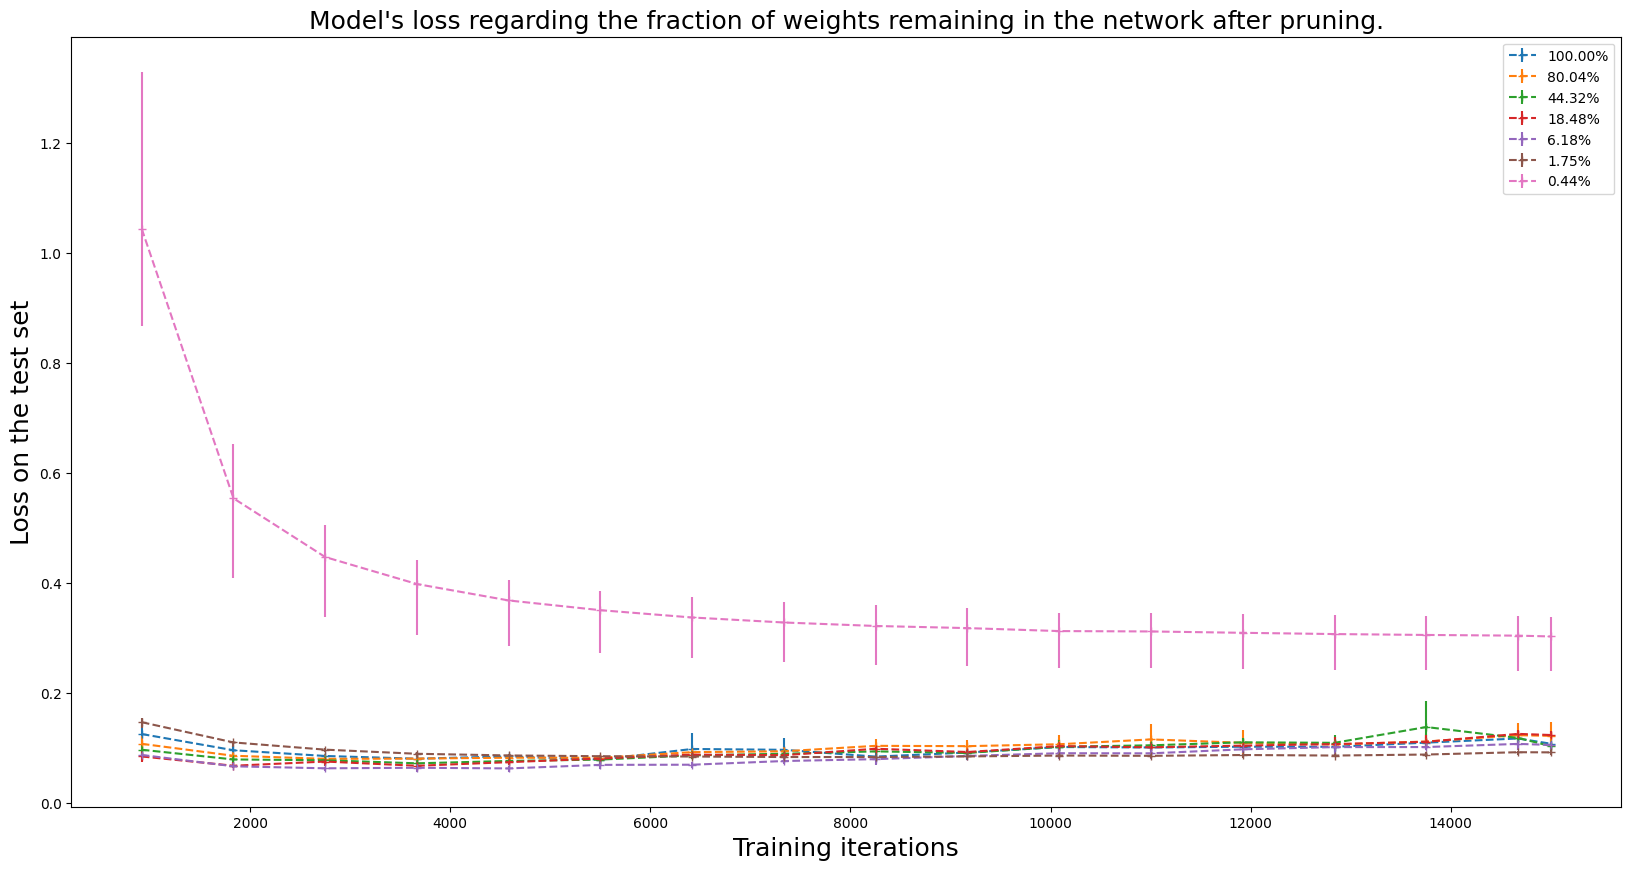

<Figure size 640x480 with 0 Axes>

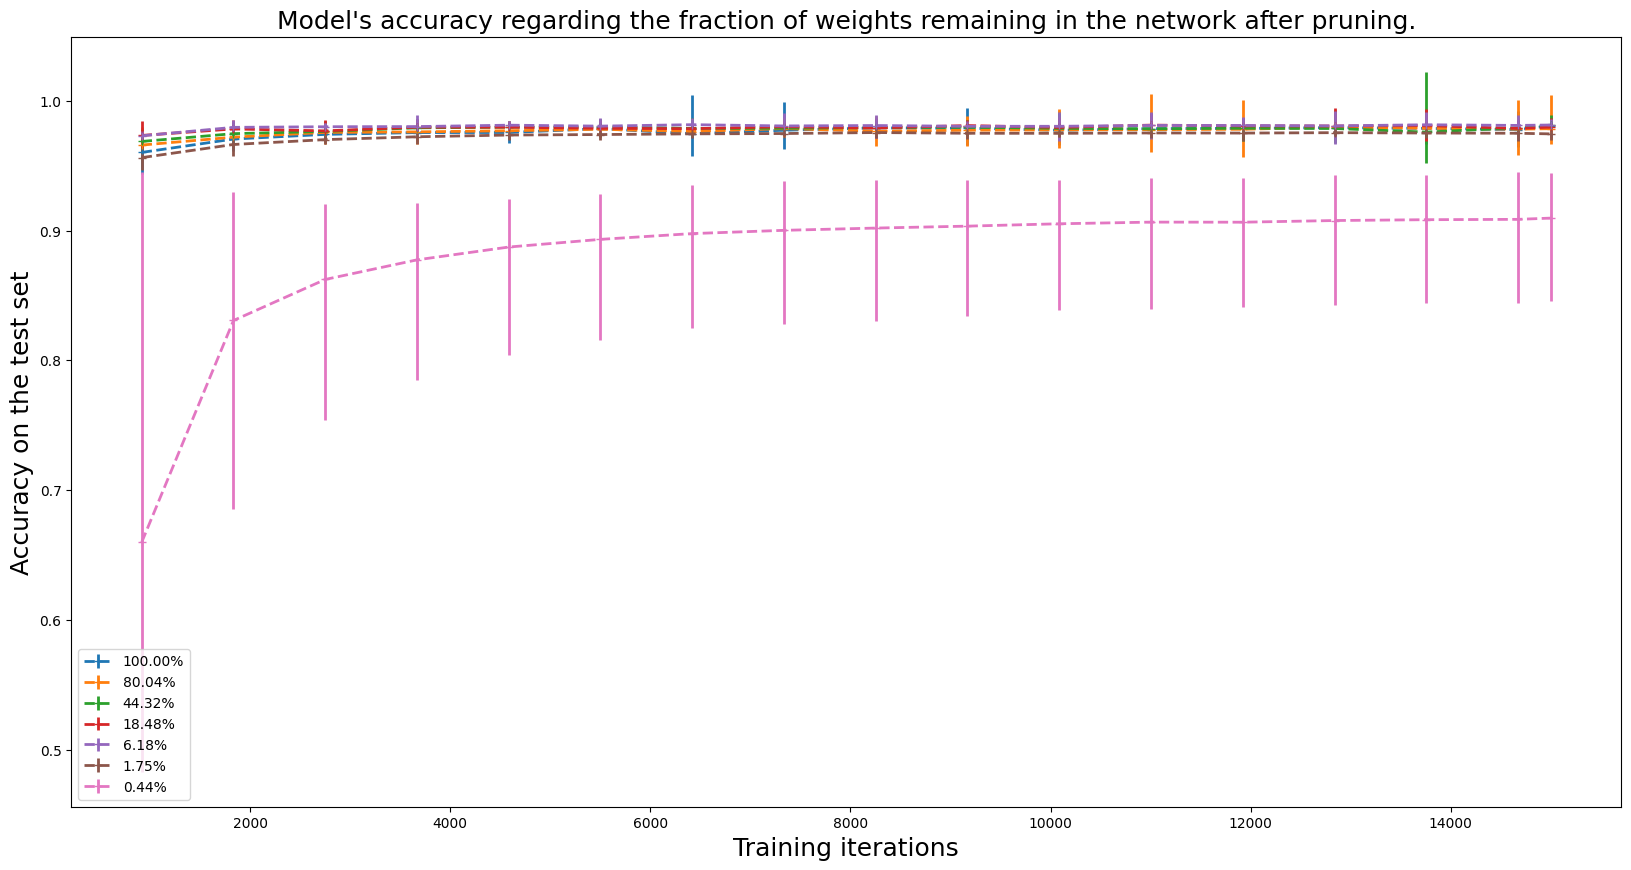

<Figure size 640x480 with 0 Axes>

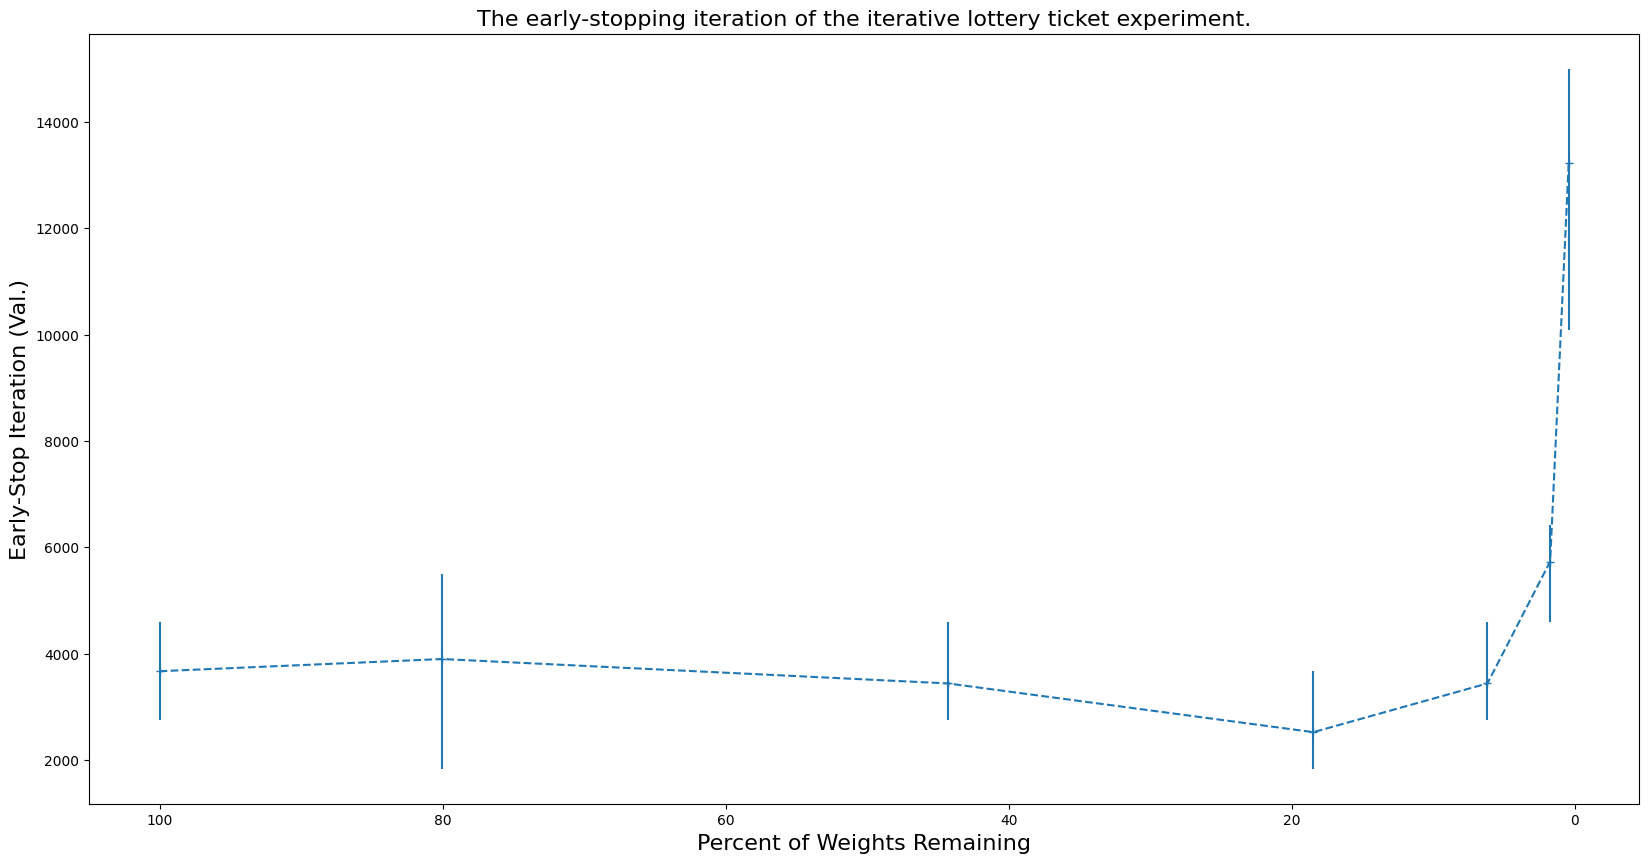

In [ ]:
plot_experiment(test_losses, test_accuracies, early_stops)